# ML Model for Transport Risk Mitigation  

The objective is to develop ML models using the provided dataset, to predict potentially dangerous temperature and humidity conditions while transporting high-value goods, including livestock and perishable food items. By analyzing telematics, weather data, and sensor readings, the model will uncover the influence of external weather, geolocation, and internal microclimate on transport conditions.  

The primary goal is to forecast instances where temperatures may exceed 25°C and/or humidity levels may surpass 80%.  

Data source : https://drive.google.com/drive/folders/1_-Eh_BXhjSkKtJ-s1rrMXxsE9Z6EfteN  


- Analytics
  - Find correlations between geolocation, external weather, timestamp, and internal microclimate data. How are these pillars interconnected?
  - How does this interconnectedness influence the risk of dangerous temperatures or humidity?
  - How do specific weather events (like high winds) or variables such as the proximity of farms to roads contribute to temperature risk?
  - How can the risk of temperature or humidity-related issues be minimized for long-distance transportation events?
  - What combination of internal and external weather factors conclude an ideal temperature that is less than 25 degree celsius and less than 80% humidity?

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime

# Third Party
import pandas as pd
import numpy as np


# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# Definitions

In [2]:
PATH_DATA = "data"
path_data = os.path.join(PATH_DATA, "inner.csv")

# Load Data

In [3]:
# load
df_raw = pd.read_csv(path_data)
df_raw

pkId  fkLinkSerialId            timestamp  speed  acceleration  \
0       2595655  0X0004BFD0379C  2022-05-07 07:40:48      0             1   
1       2595655  0X0004BFD0379C  2022-05-07 07:40:48      0             1   
2       2595657  0X0004BFD0379C  2022-05-07 07:41:24      0             1   
3       2595657  0X0004BFD0379C  2022-05-07 07:41:24      0             1   
4       2595665  0X0004BFD0379C  2022-05-07 07:43:49      0             1   
...         ...             ...                  ...    ...           ...   
405167  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0             1   
405168  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405169  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405170  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405171  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   

        heading direction  msla        lat        long  ...         place  \
0             0         N    48 -33.226616  150.961105  ...           NaN   
1             0         N    48 -33.226616  150.961105  ...           NaN   
2             0         N    28 -33.226601  150.961136  ...           NaN   
3             0         N    28 -33.226601  150.961136  ...           NaN   
4             0         N    73 -33.226665  150.961136  ...           NaN   
...         ...       ...   ...        ...         ...  ...           ...   
405167        0         N   362  43.481396  -81.068588  ...  Sebringville   
405168        0         N   355  43.481373  -81.068619  ...  Sebringville   
405169        0         N   355  43.481373  -81.068619  ...  Sebringville   
405170        0         N   355  43.481373  -81.068619  ...  Sebringville   
405171        0         N   355  43.481373  -81.068619  ...  Sebringville   

        region locality neighborhood  postcode  country  fkReadingsId  \
0       AU-NSW      NaN          NaN       NaN       au       2595655   
1       AU-NSW      NaN          NaN       NaN       au       2595655   
2       AU-NSW      NaN          NaN       NaN       au       2595657   
3       AU-NSW      NaN          NaN       NaN       au       2595657   
4       AU-NSW      NaN          NaN       NaN       au       2595665   
...        ...      ...          ...       ...      ...           ...   
405167   CA-ON      NaN          NaN   N0K 1X0       ca       3590705   
405168   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405169   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405170   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405171   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   

        fkSensorSerialId  measurement  value  
0               0XC07A1A  temperature  17.17  
1               0XC07A1A     humidity  45.44  
2               0XC07BAE  temperature  17.55  
3               0XC07BAE     humidity  44.66  
4               0XC07A1A  temperature  17.09  
...                  ...          ...    ...  
405167          0XC08294     humidity  99.99  
405168          0XC0794D  temperature  11.47  
405169          0XC0794D     humidity  99.99  
405170          0XC079D9  temperature  11.42  
405171          0XC079D9     humidity  99.99  

[405172 rows x 43 columns]

## Missing values

Drop columns uvi and dew-point because no data

In [4]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_raw)

missing data : 
region            3452
value             4761
place            26432
accuracy         26484
postcode         26690
wind_gust        79564
neighborhood    363660
locality        378704
snow            384626
rain            384844
uvi             405172
dew_point       405172
dtype: int64

on 405172 samples


In [5]:
list_all_nan = nb_missing.index[nb_missing.values == df_raw.shape[0]].to_list()
print(list_all_nan)
df = df_raw.drop(columns=list_all_nan).copy()
df

['uvi', 'dew_point']


pkId  fkLinkSerialId            timestamp  speed  acceleration  \
0       2595655  0X0004BFD0379C  2022-05-07 07:40:48      0             1   
1       2595655  0X0004BFD0379C  2022-05-07 07:40:48      0             1   
2       2595657  0X0004BFD0379C  2022-05-07 07:41:24      0             1   
3       2595657  0X0004BFD0379C  2022-05-07 07:41:24      0             1   
4       2595665  0X0004BFD0379C  2022-05-07 07:43:49      0             1   
...         ...             ...                  ...    ...           ...   
405167  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0             1   
405168  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405169  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405170  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405171  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   

        heading direction  msla        lat        long  ...         place  \
0             0         N    48 -33.226616  150.961105  ...           NaN   
1             0         N    48 -33.226616  150.961105  ...           NaN   
2             0         N    28 -33.226601  150.961136  ...           NaN   
3             0         N    28 -33.226601  150.961136  ...           NaN   
4             0         N    73 -33.226665  150.961136  ...           NaN   
...         ...       ...   ...        ...         ...  ...           ...   
405167        0         N   362  43.481396  -81.068588  ...  Sebringville   
405168        0         N   355  43.481373  -81.068619  ...  Sebringville   
405169        0         N   355  43.481373  -81.068619  ...  Sebringville   
405170        0         N   355  43.481373  -81.068619  ...  Sebringville   
405171        0         N   355  43.481373  -81.068619  ...  Sebringville   

        region locality neighborhood  postcode  country  fkReadingsId  \
0       AU-NSW      NaN          NaN       NaN       au       2595655   
1       AU-NSW      NaN          NaN       NaN       au       2595655   
2       AU-NSW      NaN          NaN       NaN       au       2595657   
3       AU-NSW      NaN          NaN       NaN       au       2595657   
4       AU-NSW      NaN          NaN       NaN       au       2595665   
...        ...      ...          ...       ...      ...           ...   
405167   CA-ON      NaN          NaN   N0K 1X0       ca       3590705   
405168   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405169   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405170   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405171   CA-ON      NaN          NaN   N0K 1X0       ca       3590722   

        fkSensorSerialId  measurement  value  
0               0XC07A1A  temperature  17.17  
1               0XC07A1A     humidity  45.44  
2               0XC07BAE  temperature  17.55  
3               0XC07BAE     humidity  44.66  
4               0XC07A1A  temperature  17.09  
...                  ...          ...    ...  
405167          0XC08294     humidity  99.99  
405168          0XC0794D  temperature  11.47  
405169          0XC0794D     humidity  99.99  
405170          0XC079D9  temperature  11.42  
405171          0XC079D9     humidity  99.99  

[405172 rows x 41 columns]

# Data structure

Nb vehicules

In [6]:
df["fkLinkSerialId"].nunique()

9

Text(0.5, 1.0, 'nb of measurements by vehicle')

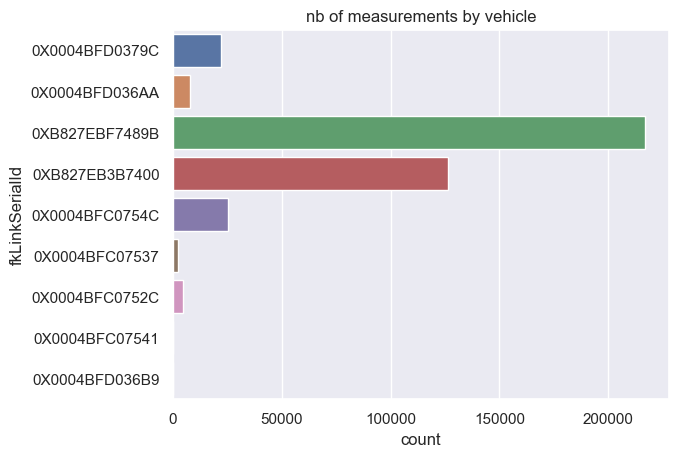

In [7]:
sns.countplot(data=df, y="fkLinkSerialId")
plt.title("nb of measurements by vehicle")

In [8]:
df["pkId"].nunique()

124249

In [9]:
db_nb_data = df[["timestamp", "pkId"]].groupby(["pkId"]).count()
db_nb_data

timestamp
pkId              
2595655          2
2595657          2
2595665          2
2595667          2
2595675          2
...            ...
3590602          4
3590619          6
3590636          2
3590705          6
3590722          4

[124249 rows x 1 columns]

In [10]:
df.shape[0]

405172

In [11]:
db_nb_data.describe()

timestamp
count  124249.000000
mean        3.260968
std         2.215288
min         2.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        14.000000

In [12]:
db_nb_data[db_nb_data["timestamp"] == 14]

timestamp
pkId              
2606172         14
2606226         14
2606277         14
2606490         14
2606647         14
...            ...
3233789         14
3235199         14
3245579         14
3245726         14
3245742         14

[1081 rows x 1 columns]

In [13]:
df[df["pkId"] == 2606172]

pkId  fkLinkSerialId            timestamp  speed  acceleration  \
4248  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4249  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4250  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4251  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4252  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4253  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4254  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4255  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4256  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4257  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4258  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4259  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4260  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   
4261  2606172  0XB827EBF7489B  2022-05-09 08:02:52      0             1   

      heading direction  msla        lat       long  ...           place  \
4248        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4249        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4250        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4251        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4252        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4253        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4254        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4255        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4256        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4257        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4258        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4259        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4260        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   
4261        0         N   365  43.604435 -80.308678  ...  Guelph/Eramosa   

     region locality neighborhood  postcode  country  fkReadingsId  \
4248  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4249  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4250  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4251  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4252  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4253  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4254  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4255  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4256  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4257  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4258  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4259  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4260  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   
4261  CA-ON      NaN          NaN   N1H 6J2       ca       2606172   

      fkSensorSerialId  measurement  value  
4248          0XC07745  temperature  16.24  
4249          0XC07745     humidity  30.78  
4250          0XC07A39  temperature  16.04  
4251          0XC07A39     humidity  30.59  
4252          0XC07A5C  temperature  15.96  
4253          0XC07A5C     humidity  31.61  
4254          0XC07B5E  temperature  16.09  
4255          0XC07B5E     humidity  30.26  
4256          0XC07B98  temperature  16.33  
4257          0XC07B98     humidity  30.48  
4258          0XC07B9A  temperature  15.64  
4259          0XC07B9A     humidity  30.74  
4260          0XC07BF5  temperature  16.00  
4261          0XC07BF5     humidity  30.65  

[14 rows x 41 c

In [14]:
db_nb_data["timestamp"].max()

14

In [15]:
db_nb_data["timestamp"].min()

2

In [16]:
#def fun_diff(list_in):
#    return  np.all(np.array(list_in ) == list_in[0])

db_nb_readings = df[["fkReadingsId", "pkId"]].groupby(["pkId"]).nunique()
db_nb_readings.describe()

fkReadingsId
count      124249.0
mean            1.0
std             0.0
min             1.0
25%             1.0
50%             1.0
75%             1.0
max             1.0

###  Unify multiple internal sensors

=> Each fkReadingsId is linked with one pkId

We can aggregate sensors in the vehicle.  
=> Create : mean / max / min value  for T°C and Humidity %

In [17]:
df_temp = df[df["measurement"] == "temperature"].copy()
print(df_temp.shape)
df_humi = df[df["measurement"] == "humidity"].copy()
print(df_humi.shape)

(202586, 41)
(202586, 41)


Check internal temperature error

In [18]:
df_temp["temp_nok"] = df_temp["value"] > (df_temp["temp"] + 35)
df_temp["temp_high"] = (df_temp["value"] > 45) 


<AxesSubplot: xlabel='count', ylabel='fkLinkSerialId'>

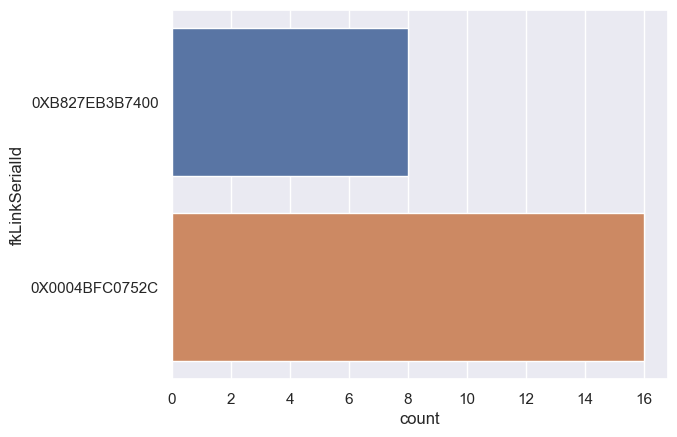

In [19]:
sns.countplot(data=df_temp[df_temp["temp_nok"]], y="fkLinkSerialId") 

<AxesSubplot: xlabel='count', ylabel='country'>

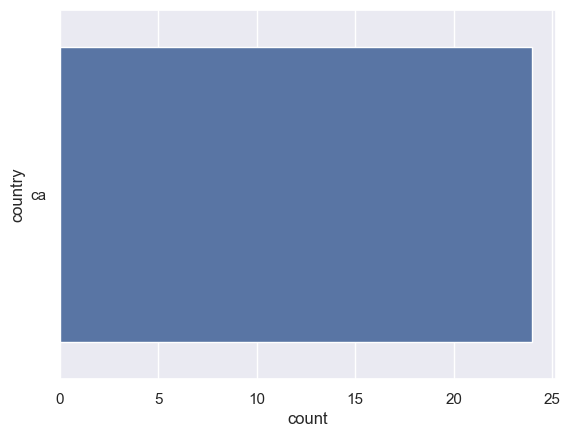

In [20]:
sns.countplot(data=df_temp[df_temp["temp_nok"]], y="country") 

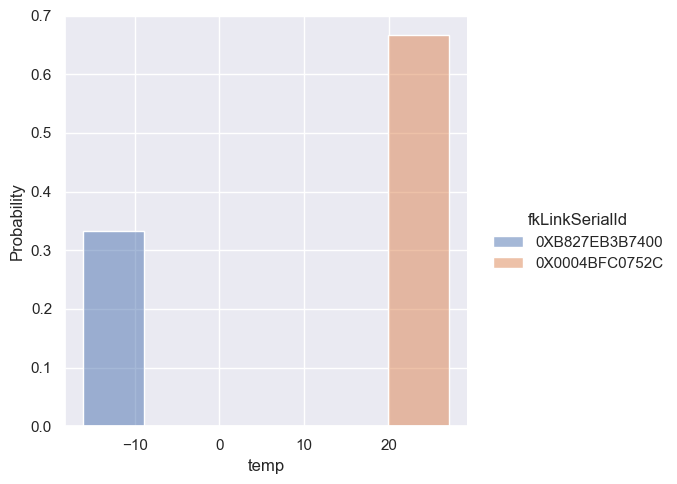

In [21]:
# df_temp[df_temp["temp_nok"]]
sns.displot(data=df_temp[df_temp["temp_nok"]], x="temp", stat="probability" , hue="fkLinkSerialId") 

In [22]:
df_temp[df_temp["temp_nok"]]["fkLinkSerialId"].unique()

array(['0XB827EB3B7400', '0X0004BFC0752C'], dtype=object)

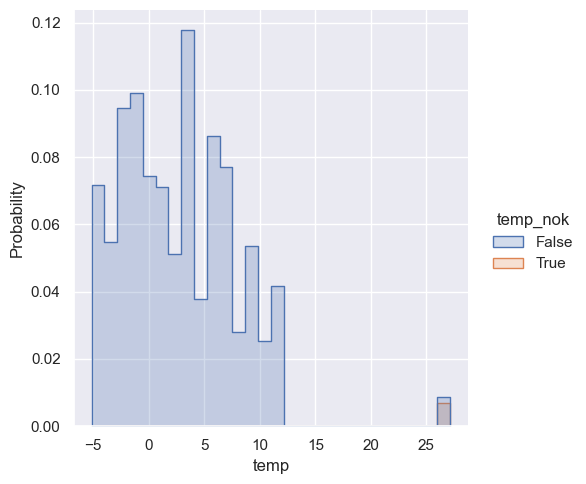

In [23]:
sns.displot(
    data=df_temp[df_temp["fkLinkSerialId"] == "0X0004BFC0752C"], 
    x="temp", 
    stat="probability", 
    hue="temp_nok",
    element="step") 

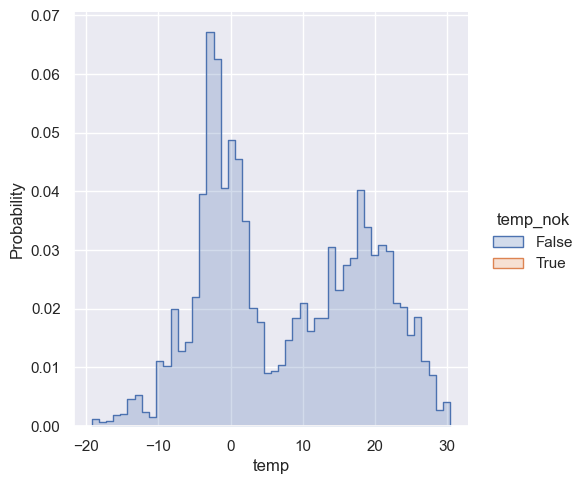

In [24]:
sns.displot(
    data=df_temp[df_temp["fkLinkSerialId"] == "0XB827EB3B7400"], 
    x="temp", 
    stat="probability", 
    hue="temp_nok",
    element="step") 

<AxesSubplot: xlabel='temp_nok', ylabel='count'>

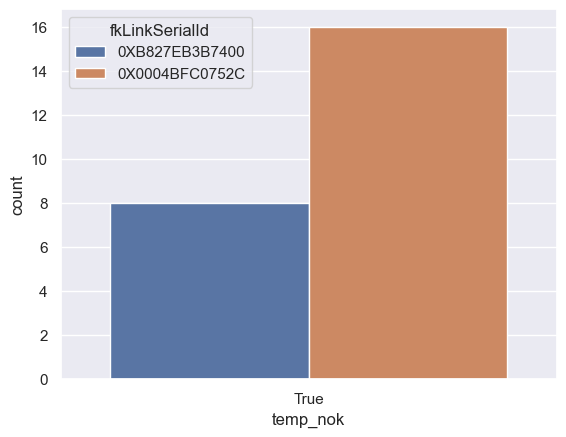

In [25]:
sns.countplot(data=df_temp[df_temp["temp_nok"]], x="temp_nok", hue="fkLinkSerialId")

<AxesSubplot: xlabel='temp_high', ylabel='count'>

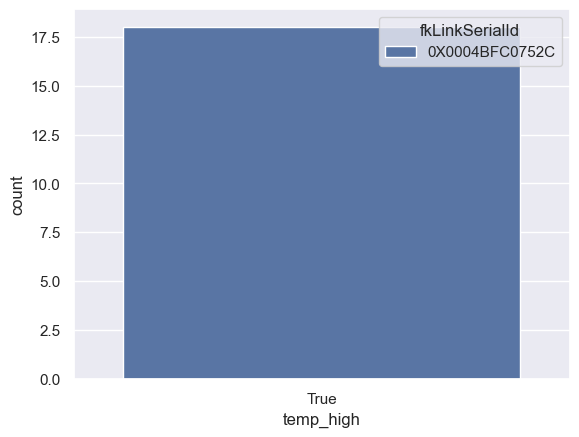

In [26]:
sns.countplot(data=df_temp[df_temp["temp_high"]], x="temp_high", hue="fkLinkSerialId")

<AxesSubplot: xlabel='temp_nok', ylabel='count'>

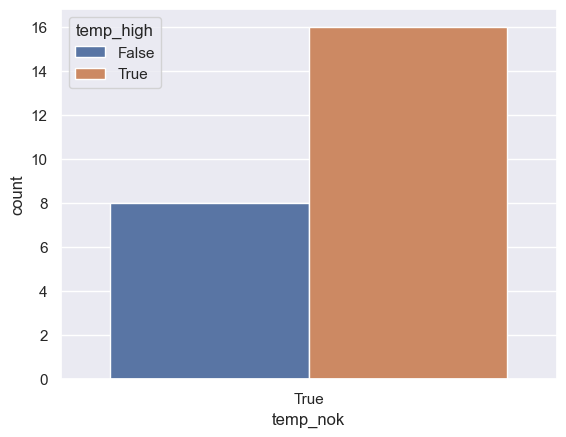

In [27]:
sns.countplot(data=df_temp[df_temp["temp_nok"]], x="temp_nok", hue="temp_high")

<AxesSubplot: xlabel='temp_high', ylabel='count'>

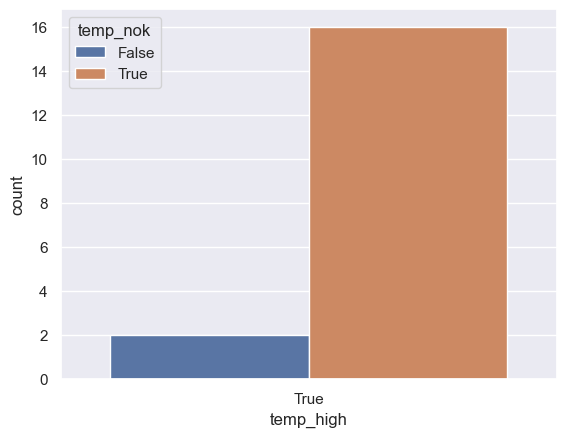

In [28]:
sns.countplot(data=df_temp[df_temp["temp_high"]], x="temp_high", hue="temp_nok")

#### Clean internal temp error

In [29]:
print(df_temp.shape[0])
df_temp = df_temp[(df_temp["temp_nok"] == False) & (df_temp["temp_high"] == False)]
print(df_temp.shape[0])

202586
202560


In [30]:
df_temp_agg =  df_temp.groupby(["fkReadingsId"]).agg(
    temp_mean = ("value", "mean"),
    temp_min = ("value", "min"),
    temp_max = ("value", "max"),
)
df_temp_agg

temp_mean  temp_min  temp_max
fkReadingsId                               
2595655          17.170     17.17     17.17
2595657          17.550     17.55     17.55
2595665          17.090     17.09     17.09
2595667          17.480     17.48     17.48
2595675          18.550     18.55     18.55
...                 ...       ...       ...
3590602          12.000     11.84     12.16
3590619          12.090     11.74     12.44
3590636          12.010     12.01     12.01
3590705          12.040     11.72     12.38
3590722          11.445     11.42     11.47

[124232 rows x 3 columns]

In [31]:
df_test = df_temp_agg.copy()
df_test.reset_index(inplace=True)
df_test["point"] = df_test.index.values
df_test["temp_error"]  = df_test["temp_max"] - df_test["temp_min"]
df_test["temp_too_high"] = df_test["temp_max"] > (df_test["temp_mean"] + 5)
df_test

fkReadingsId  temp_mean  temp_min  temp_max   point  temp_error  \
0            2595655     17.170     17.17     17.17       0        0.00   
1            2595657     17.550     17.55     17.55       1        0.00   
2            2595665     17.090     17.09     17.09       2        0.00   
3            2595667     17.480     17.48     17.48       3        0.00   
4            2595675     18.550     18.55     18.55       4        0.00   
...              ...        ...       ...       ...     ...         ...   
124227       3590602     12.000     11.84     12.16  124227        0.32   
124228       3590619     12.090     11.74     12.44  124228        0.70   
124229       3590636     12.010     12.01     12.01  124229        0.00   
124230       3590705     12.040     11.72     12.38  124230        0.66   
124231       3590722     11.445     11.42     11.47  124231        0.05   

        temp_too_high  
0               False  
1               False  
2               False  
3               False  
4               False  
...               ...  
124227          False  
124228          False  
124229          False  
124230          False  
124231          False  

[124232 rows x 7 columns]

In [32]:
df_test["temp_error"]

0         0.00
1         0.00
2         0.00
3         0.00
4         0.00
          ... 
124227    0.32
124228    0.70
124229    0.00
124230    0.66
124231    0.05
Name: temp_error, Length: 124232, dtype: float64

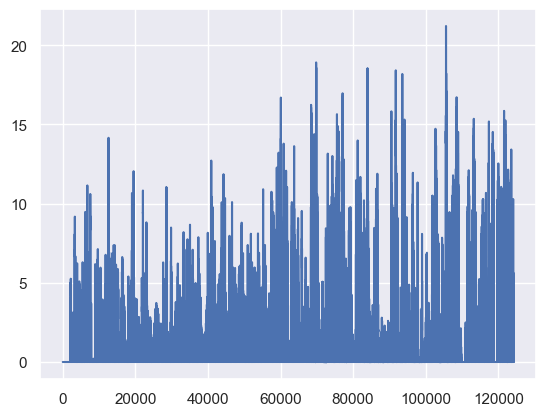

In [33]:
plt.plot(df_test["temp_error"])

<AxesSubplot: xlabel='temp_mean', ylabel='temp_max'>

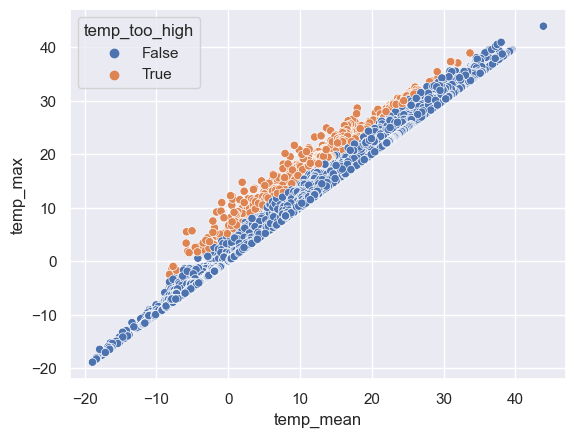

In [34]:
sns.scatterplot(data=df_test,x="temp_mean", y="temp_max", hue="temp_too_high")

<AxesSubplot: xlabel='point', ylabel='temp_max'>

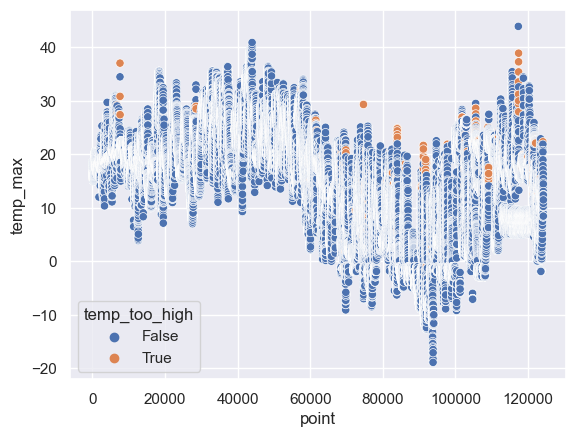

In [35]:
sns.scatterplot(data=df_test,x="point", y="temp_max", hue="temp_too_high")

<AxesSubplot: xlabel='point', ylabel='temp_error'>

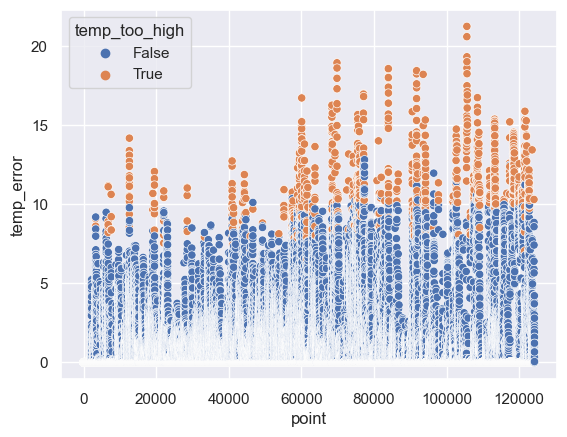

In [36]:

sns.scatterplot(data=df_test,x="point", y="temp_error", hue="temp_too_high")

### Check humidity sensor

<AxesSubplot: xlabel='value'>

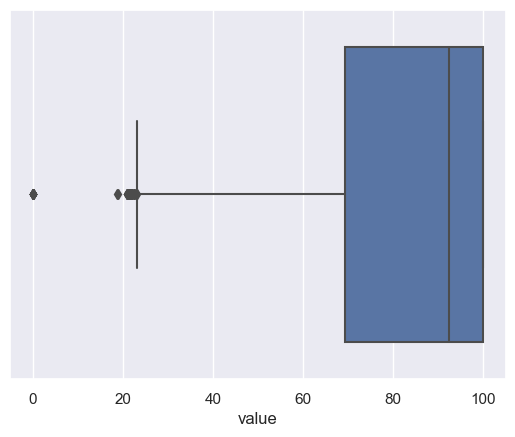

In [37]:
sns.boxplot(data=df_humi, x="value")

In [38]:
df_humi_agg = df_humi.groupby(["fkReadingsId"]).agg(
    humi_mean = ("value", "mean"),
    humi_min = ("value", "min"),
    humi_max = ("value", "max"),
)
df_humi_agg

humi_mean  humi_min  humi_max
fkReadingsId                               
2595655           45.44     45.44     45.44
2595657           44.66     44.66     44.66
2595665           45.53     45.53     45.53
2595667           44.74     44.74     44.74
2595675           45.62     45.62     45.62
...                 ...       ...       ...
3590602           97.63     95.27     99.99
3590619           98.53     95.61     99.99
3590636           99.99     99.99     99.99
3590705           98.91     96.75     99.99
3590722           99.99     99.99     99.99

[124249 rows x 3 columns]

In [39]:
df_test = df_humi_agg.copy()
df_test.reset_index(inplace=True)
df_test["point"] = df_test.index.values
df_test["humi_error"] = df_test["humi_max"] - df_test["humi_min"]
df_test["humi_nok"] = df_test["humi_error"] > 20

<AxesSubplot: xlabel='humi_nok', ylabel='count'>

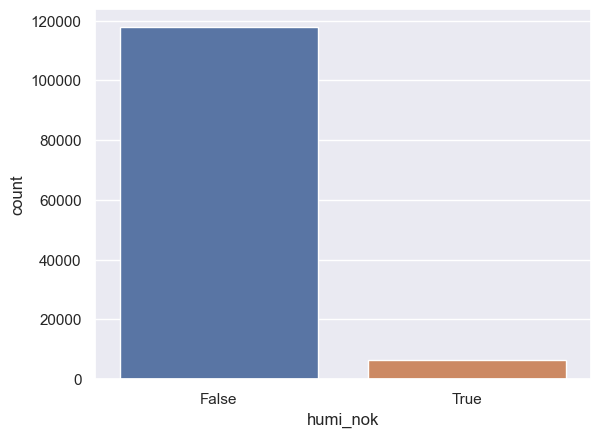

In [40]:
sns.countplot(data=df_test, x="humi_nok")

In [41]:
df[df["fkReadingsId"] == 3590722 ]

pkId  fkLinkSerialId            timestamp  speed  acceleration  \
405168  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405169  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405170  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   
405171  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0             1   

        heading direction  msla        lat       long  ...         place  \
405168        0         N   355  43.481373 -81.068619  ...  Sebringville   
405169        0         N   355  43.481373 -81.068619  ...  Sebringville   
405170        0         N   355  43.481373 -81.068619  ...  Sebringville   
405171        0         N   355  43.481373 -81.068619  ...  Sebringville   

       region locality neighborhood  postcode  country  fkReadingsId  \
405168  CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405169  CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405170  CA-ON      NaN          NaN   N0K 1X0       ca       3590722   
405171  CA-ON      NaN          NaN   N0K 1X0       ca       3590722   

        fkSensorSerialId  measurement  value  
405168          0XC0794D  temperature  11.47  
405169          0XC0794D     humidity  99.99  
405170          0XC079D9  temperature  11.42  
405171          0XC079D9     humidity  99.99  

[4 rows x 41 columns]

In [42]:
df_uni = df.groupby("fkReadingsId").nunique()
df_uni

pkId  fkLinkSerialId  timestamp  speed  acceleration  heading  \
fkReadingsId                                                                  
2595655          1               1          1      1             1        1   
2595657          1               1          1      1             1        1   
2595665          1               1          1      1             1        1   
2595667          1               1          1      1             1        1   
2595675          1               1          1      1             1        1   
...            ...             ...        ...    ...           ...      ...   
3590602          1               1          1      1             1        1   
3590619          1               1          1      1             1        1   
3590636          1               1          1      1             1        1   
3590705          1               1          1      1             1        1   
3590722          1               1          1      1             1        1   

              direction  msla  lat  long  ...  text  place  region  locality  \
fkReadingsId                              ...                                  
2595655               1     1    1     1  ...     1      0       1         0   
2595657               1     1    1     1  ...     1      0       1         0   
2595665               1     1    1     1  ...     1      0       1         0   
2595667               1     1    1     1  ...     1      0       1         0   
2595675               1     1    1     1  ...     1      0       1         0   
...                 ...   ...  ...   ...  ...   ...    ...     ...       ...   
3590602               1     1    1     1  ...     1      1       1         0   
3590619               1     1    1     1  ...     1      1       1         0   
3590636               1     1    1     1  ...     1      1       1         0   
3590705               1     1    1     1  ...     1      1       1         0   
3590722               1     1    1     1  ...     1      1       1         0   

              neighborhood  postcode  country  fkSensorSerialId  measurement  \
fkReadingsId                                                                   
2595655                  0         0        1                 1            2   
2595657                  0         0        1                 1            2   
2595665                  0         0        1                 1            2   
2595667                  0         0        1                 1            2   
2595675                  0         0        1                 1            2   
...                    ...       ...      ...               ...          ...   
3590602                  0         1        1                 2            2   
3590619                  0         1        1                 3            2   
3590636                  0         1        1                 1            2   
3590705                  0         1        1                 3            2   
3590722                  0         1        1                 2            2   

              value  
fkReadingsId         
2595655           2  
2595657           2  
2595665           2  
2595667           2  
2595675           2  
...             ...  
3590602           4  
3590619           5  
3590636           2  
3590705           5  
3590722           3  

[124249 rows x 40 columns]

In [43]:
df_uni.max()

pkId                 1
fkLinkSerialId       1
timestamp            1
speed                1
acceleration         1
heading              1
direction            1
msla                 1
lat                  1
long                 1
tsReceived           1
dt                   1
sunrise              1
sunset               1
temp                 1
feels_like           1
pressure             1
humidity             1
clouds               1
visibility           1
wind_speed           1
wind_gust            1
wind_deg             1
rain                 1
snow                 1
weatherid            1
place_type           1
accuracy             1
place_name           1
relevance            1
text                 1
place                1
region               1
locality             1
neighborhood         1
postcode             1
country              1
fkSensorSerialId     7
measurement          2
value               14
dtype: int64

### Select first data point for other
Each columns have only one uique data per "reading", except fkSensorSerialId, measurement & value.  
=>  we can join data

In [44]:
df_first = df.groupby("fkReadingsId").first()
df_first.reset_index(inplace=True)
df_first.drop(columns=["fkSensorSerialId", "measurement", "value"], inplace=True)
df_first

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124244       3590602  3590602  0XB827EB3B7400  2023-04-21 15:39:37      0   
124245       3590619  3590619  0XB827EB3B7400  2023-04-21 15:42:33      0   
124246       3590636  3590636  0XB827EB3B7400  2023-04-21 15:45:29      0   
124247       3590705  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0   
124248       3590722  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0   

        acceleration  heading direction  msla        lat  ...  accuracy  \
0                  1        0         N    48 -33.226616  ...      None   
1                  1        0         N    28 -33.226601  ...      None   
2                  1        0         N    73 -33.226665  ...      None   
3                  1        0         N    62 -33.226707  ...      None   
4                  1        0         N    34 -33.226757  ...      None   
...              ...      ...       ...   ...        ...  ...       ...   
124244             1        0         N   331  43.481373  ...     point   
124245             1        0         N   365  43.481445  ...     point   
124246             1        0         N   349  43.481346  ...     point   
124247             1        0         N   362  43.481396  ...     point   
124248             1        0         N   355  43.481373  ...     point   

                                               place_name relevance  \
0                   St Albans, New South Wales, Australia       1.0   
1                   St Albans, New South Wales, Australia       1.0   
2                   St Albans, New South Wales, Australia       1.0   
3                   St Albans, New South Wales, Australia       1.0   
4                   St Albans, New South Wales, Australia       1.0   
...                                                   ...       ...   
124244  4651 145 Road, Sebringville, Ontario N0K 1X0, ...       1.0   
124245  4651 145 Road, Sebringville, Ontario N0K 1X0, ...       1.0   
124246  4651 145 Road, Sebringville, Ontario N0K 1X0, ...       1.0   
124247  4651 145 Road, Sebringville, Ontario N0K 1X0, ...       1.0   
124248  4651 145 Road, Sebringville, Ontario N0K 1X0, ...       1.0   

             text         place  region  locality  neighborhood  postcode  \
0       St Albans          None  AU-NSW      None          None      None   
1       St Albans          None  AU-NSW      None          None      None   
2       St Albans          None  AU-NSW      None          None      None   
3       St Albans          None  AU-NSW      None          None      None   
4       St Albans          None  AU-NSW      None          None      None   
...           ...           ...     ...       ...           ...       ...   
124244   145 Road  Sebringville   CA-ON      None          None   N0K 1X0   
124245   145 Road  Sebringville   CA-ON      None          None   N0K 1X0   
124246   145 Road  Sebringville   CA-ON      None          None   N0K 1X0   
124247   145 Road  Sebringville   CA-ON      None          None   N0K 1X0   
124248   145 Road  Sebringville   CA-ON      None          None   N0K 1X0   

        country  
0            au  
1            au  
2            au  
3            au  
4            au  
...         ...  
124244       ca  
124245       ca  
124246       ca  
124247       ca  
124248       ca  

[124249 rows x 38 columns]

### Merge final datasets

In [45]:
df_agg = df_first.merge(df_temp_agg, on="fkReadingsId").merge(df_humi_agg, on="fkReadingsId")
df_agg

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124227       3590602  3590602  0XB827EB3B7400  2023-04-21 15:39:37      0   
124228       3590619  3590619  0XB827EB3B7400  2023-04-21 15:42:33      0   
124229       3590636  3590636  0XB827EB3B7400  2023-04-21 15:45:29      0   
124230       3590705  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0   
124231       3590722  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0   

        acceleration  heading direction  msla        lat  ...  locality  \
0                  1        0         N    48 -33.226616  ...      None   
1                  1        0         N    28 -33.226601  ...      None   
2                  1        0         N    73 -33.226665  ...      None   
3                  1        0         N    62 -33.226707  ...      None   
4                  1        0         N    34 -33.226757  ...      None   
...              ...      ...       ...   ...        ...  ...       ...   
124227             1        0         N   331  43.481373  ...      None   
124228             1        0         N   365  43.481445  ...      None   
124229             1        0         N   349  43.481346  ...      None   
124230             1        0         N   362  43.481396  ...      None   
124231             1        0         N   355  43.481373  ...      None   

       neighborhood postcode country temp_mean  temp_min  temp_max  humi_mean  \
0              None     None      au    17.170     17.17     17.17      45.44   
1              None     None      au    17.550     17.55     17.55      44.66   
2              None     None      au    17.090     17.09     17.09      45.53   
3              None     None      au    17.480     17.48     17.48      44.74   
4              None     None      au    18.550     18.55     18.55      45.62   
...             ...      ...     ...       ...       ...       ...        ...   
124227         None  N0K 1X0      ca    12.000     11.84     12.16      97.63   
124228         None  N0K 1X0      ca    12.090     11.74     12.44      98.53   
124229         None  N0K 1X0      ca    12.010     12.01     12.01      99.99   
124230         None  N0K 1X0      ca    12.040     11.72     12.38      98.91   
124231         None  N0K 1X0      ca    11.445     11.42     11.47      99.99   

        humi_min  humi_max  
0          45.44     45.44  
1          44.66     44.66  
2          45.53     45.53  
3          44.74     44.74  
4          45.62     45.62  
...          ...       ...  
124227     95.27     99.99  
124228     95.61     99.99  
124229     99.99     99.99  
124230     96.75     99.99  
124231     99.99     99.99  

[124232 rows x 44 columns]

In [46]:
df = df_agg.copy()

## Time

In [47]:
df[["timestamp", "tsReceived", "dt","sunrise", "sunset", "region", "country" ]]

timestamp           tsReceived                   dt  \
0       2022-05-07 07:40:48  2022-05-07 07:40:48  2022-05-07 07:40:48   
1       2022-05-07 07:41:24  2022-05-07 07:41:24  2022-05-07 07:40:48   
2       2022-05-07 07:43:49  2022-05-07 07:43:49  2022-05-07 07:40:48   
3       2022-05-07 07:44:25  2022-05-07 07:44:25  2022-05-07 07:40:48   
4       2022-05-07 07:46:51  2022-05-07 07:46:51  2022-05-07 07:40:48   
...                     ...                  ...                  ...   
124227  2023-04-21 15:39:37  2023-04-21 15:39:37  2023-04-21 15:35:57   
124228  2023-04-21 15:42:33  2023-04-21 15:42:33  2023-04-21 15:35:57   
124229  2023-04-21 15:45:29  2023-04-21 15:45:29  2023-04-21 15:35:57   
124230  2023-04-21 15:57:34  2023-04-21 15:57:34  2023-04-21 15:56:28   
124231  2023-04-21 16:00:29  2023-04-21 16:00:29  2023-04-21 15:56:28   

                    sunrise               sunset  region country  
0       2022-05-06 16:33:48  2022-05-07 03:11:39  AU-NSW      au  
1       2022-05-06 16:33:48  2022-05-07 03:11:39  AU-NSW      au  
2       2022-05-06 16:33:48  2022-05-07 03:11:39  AU-NSW      au  
3       2022-05-06 16:33:48  2022-05-07 03:11:39  AU-NSW      au  
4       2022-05-06 16:33:48  2022-05-07 03:11:39  AU-NSW      au  
...                     ...                  ...     ...     ...  
124227  2023-04-21 06:32:12  2023-04-21 20:13:26   CA-ON      ca  
124228  2023-04-21 06:32:12  2023-04-21 20:13:26   CA-ON      ca  
124229  2023-04-21 06:32:12  2023-04-21 20:13:26   CA-ON      ca  
124230  2023-04-21 06:32:12  2023-04-21 20:13:26   CA-ON      ca  
124231  2023-04-21 06:32:12  2023-04-21 20:13:26   CA-ON      ca  

[124232 rows x 7 columns]

In [48]:
print(df[df["country"] == "au"]["sunrise"].astype(np.datetime64).dt.hour.max())
print(df[df["country"] == "au"]["sunrise"].astype(np.datetime64).dt.hour.min())

16
16


In [49]:
print(df[df["country"] == "au"]["sunset"].astype(np.datetime64).dt.hour.max())
print(df[df["country"] == "au"]["sunset"].astype(np.datetime64).dt.hour.min())

3
2


In [50]:
df[df["country"] == "au"]["sunrise"].max()

'2022-05-29 16:49:49'

In [51]:
df[df["country"] == "au"]["region"].unique()

array(['AU-NSW'], dtype=object)

In [52]:
df[df["country"] == "ie"]["sunrise"].unique()

array(['2023-03-17 02:34:56', '2023-03-18 02:32:30'], dtype=object)

In [53]:
df[["country","sunrise", "sunset", "timestamp"]].groupby("country").agg(
    sunrise_min = ("sunrise", lambda x: x.astype(np.datetime64).dt.hour.min()),
    sunrise_max = ("sunrise", lambda x: x.astype(np.datetime64).dt.hour.max()),
    sunset_min = ("sunset", lambda x: x.astype(np.datetime64).dt.hour.min()),
    sunset_max = ("sunset", lambda x: x.astype(np.datetime64).dt.hour.max()),
    time_min = ("timestamp", lambda x: x.astype(np.datetime64).dt.hour.min()),
    time_max = ("timestamp", lambda x: x.astype(np.datetime64).dt.hour.max()),    
)

sunrise_min  sunrise_max  sunset_min  sunset_max  time_min  time_max
country                                                                      
au                16           16           2           3         0        23
ca                 4            8          16          21         0        23
dk                 0            1          13          14         0        23
ie                 2            2          14          14         6        19
us                 5            8          16          21         0        23

=> All times seem to be on same time slot:  probably in US

## add daylight data
if sunrise < time < sunset => daylight =  Sin (delta time with sun rise / (sunrise-sunset))

In [54]:
def fun_date_to_num(str_date):
    return int(pd.Timestamp(str_date).timestamp())

def cos_norm(value, period, rotate=False):
    if rotate:
        a_rotate = math.pi
    else:
        a_rotate = 0
    return np.cos(2*math.pi * value / period + a_rotate)

def sin_norm(value, period, rotate=False):
    if rotate:
        a_rotate = math.pi
    else:
        a_rotate = 0
    return np.sin(2*math.pi * value / period + a_rotate)


df_sun = df.copy()[["fkReadingsId","timestamp","sunrise", "sunset" ]]
df_sun["time_num"] = df_sun["timestamp"].apply(fun_date_to_num)
df_sun["sunrise_num"] = df_sun["sunrise"].apply(fun_date_to_num)
df_sun["sunset_num"] = df_sun["sunset"].apply(fun_date_to_num)
df_sun["ratio_period"] = (df_sun["time_num"] - df_sun["sunrise_num"]) / (df_sun["sunset_num"] - df_sun["sunrise_num"]) # not good when daylight
df_sun["daylight"] = df_sun["ratio_period"].apply(sin_norm, args=(2,))
df_sun["daylight"] = df_sun["daylight"].where(df_sun["daylight"] >0, 0)
df_sun["b_daylight"] = (
    (df_sun["time_num"] > df_sun["sunrise_num"]) & 
    (df_sun["time_num"] < df_sun["sunset_num"])
)

df_sun

fkReadingsId            timestamp              sunrise  \
0            2595655  2022-05-07 07:40:48  2022-05-06 16:33:48   
1            2595657  2022-05-07 07:41:24  2022-05-06 16:33:48   
2            2595665  2022-05-07 07:43:49  2022-05-06 16:33:48   
3            2595667  2022-05-07 07:44:25  2022-05-06 16:33:48   
4            2595675  2022-05-07 07:46:51  2022-05-06 16:33:48   
...              ...                  ...                  ...   
124227       3590602  2023-04-21 15:39:37  2023-04-21 06:32:12   
124228       3590619  2023-04-21 15:42:33  2023-04-21 06:32:12   
124229       3590636  2023-04-21 15:45:29  2023-04-21 06:32:12   
124230       3590705  2023-04-21 15:57:34  2023-04-21 06:32:12   
124231       3590722  2023-04-21 16:00:29  2023-04-21 06:32:12   

                     sunset    time_num  sunrise_num  sunset_num  \
0       2022-05-07 03:11:39  1651909248   1651854828  1651893099   
1       2022-05-07 03:11:39  1651909284   1651854828  1651893099   
2       2022-05-07 03:11:39  1651909429   1651854828  1651893099   
3       2022-05-07 03:11:39  1651909465   1651854828  1651893099   
4       2022-05-07 03:11:39  1651909611   1651854828  1651893099   
...                     ...         ...          ...         ...   
124227  2023-04-21 20:13:26  1682091577   1682058732  1682108006   
124228  2023-04-21 20:13:26  1682091753   1682058732  1682108006   
124229  2023-04-21 20:13:26  1682091929   1682058732  1682108006   
124230  2023-04-21 20:13:26  1682092654   1682058732  1682108006   
124231  2023-04-21 20:13:26  1682092829   1682058732  1682108006   

        ratio_period  daylight  b_daylight  
0           1.421964  0.000000       False  
1           1.422905  0.000000       False  
2           1.426694  0.000000       False  
3           1.427635  0.000000       False  
4           1.431449  0.000000       False  
...              ...       ...         ...  
124227      0.666579  0.866164        True  
124228      0.670151  0.860501        True  
124229      0.673722  0.854730        True  
124230      0.688436  0.829832        True  
124231      0.691988  0.823555        True  

[124232 rows x 10 columns]

In [55]:
df = df.merge(df_sun[["fkReadingsId", "time_num", "daylight", "b_daylight"]], on="fkReadingsId")
df

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124227       3590602  3590602  0XB827EB3B7400  2023-04-21 15:39:37      0   
124228       3590619  3590619  0XB827EB3B7400  2023-04-21 15:42:33      0   
124229       3590636  3590636  0XB827EB3B7400  2023-04-21 15:45:29      0   
124230       3590705  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0   
124231       3590722  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0   

        acceleration  heading direction  msla        lat  ...  country  \
0                  1        0         N    48 -33.226616  ...       au   
1                  1        0         N    28 -33.226601  ...       au   
2                  1        0         N    73 -33.226665  ...       au   
3                  1        0         N    62 -33.226707  ...       au   
4                  1        0         N    34 -33.226757  ...       au   
...              ...      ...       ...   ...        ...  ...      ...   
124227             1        0         N   331  43.481373  ...       ca   
124228             1        0         N   365  43.481445  ...       ca   
124229             1        0         N   349  43.481346  ...       ca   
124230             1        0         N   362  43.481396  ...       ca   
124231             1        0         N   355  43.481373  ...       ca   

       temp_mean temp_min temp_max humi_mean  humi_min  humi_max    time_num  \
0         17.170    17.17    17.17     45.44     45.44     45.44  1651909248   
1         17.550    17.55    17.55     44.66     44.66     44.66  1651909284   
2         17.090    17.09    17.09     45.53     45.53     45.53  1651909429   
3         17.480    17.48    17.48     44.74     44.74     44.74  1651909465   
4         18.550    18.55    18.55     45.62     45.62     45.62  1651909611   
...          ...      ...      ...       ...       ...       ...         ...   
124227    12.000    11.84    12.16     97.63     95.27     99.99  1682091577   
124228    12.090    11.74    12.44     98.53     95.61     99.99  1682091753   
124229    12.010    12.01    12.01     99.99     99.99     99.99  1682091929   
124230    12.040    11.72    12.38     98.91     96.75     99.99  1682092654   
124231    11.445    11.42    11.47     99.99     99.99     99.99  1682092829   

        daylight  b_daylight  
0       0.000000       False  
1       0.000000       False  
2       0.000000       False  
3       0.000000       False  
4       0.000000       False  
...          ...         ...  
124227  0.866164        True  
124228  0.860501        True  
124229  0.854730        True  
124230  0.829832        True  
124231  0.823555        True  

[124232 rows x 47 columns]

In [56]:
df[["timestamp","sunrise", "sunset", "daylight", "region", "country" ]]

timestamp              sunrise               sunset  \
0       2022-05-07 07:40:48  2022-05-06 16:33:48  2022-05-07 03:11:39   
1       2022-05-07 07:41:24  2022-05-06 16:33:48  2022-05-07 03:11:39   
2       2022-05-07 07:43:49  2022-05-06 16:33:48  2022-05-07 03:11:39   
3       2022-05-07 07:44:25  2022-05-06 16:33:48  2022-05-07 03:11:39   
4       2022-05-07 07:46:51  2022-05-06 16:33:48  2022-05-07 03:11:39   
...                     ...                  ...                  ...   
124227  2023-04-21 15:39:37  2023-04-21 06:32:12  2023-04-21 20:13:26   
124228  2023-04-21 15:42:33  2023-04-21 06:32:12  2023-04-21 20:13:26   
124229  2023-04-21 15:45:29  2023-04-21 06:32:12  2023-04-21 20:13:26   
124230  2023-04-21 15:57:34  2023-04-21 06:32:12  2023-04-21 20:13:26   
124231  2023-04-21 16:00:29  2023-04-21 06:32:12  2023-04-21 20:13:26   

        daylight  region country  
0       0.000000  AU-NSW      au  
1       0.000000  AU-NSW      au  
2       0.000000  AU-NSW      au  
3       0.000000  AU-NSW      au  
4       0.000000  AU-NSW      au  
...          ...     ...     ...  
124227  0.866164   CA-ON      ca  
124228  0.860501   CA-ON      ca  
124229  0.854730   CA-ON      ca  
124230  0.829832   CA-ON      ca  
124231  0.823555   CA-ON      ca  

[124232 rows x 6 columns]

In [57]:
df[df["daylight"]>0.9][["timestamp","sunrise", "sunset", "daylight", "region", "country" ]]

timestamp              sunrise               sunset  \
561     2022-05-07 20:22:03  2022-05-07 16:34:32  2022-05-08 03:10:48   
562     2022-05-07 20:22:39  2022-05-07 16:34:32  2022-05-08 03:10:48   
563     2022-05-07 20:24:46  2022-05-07 16:34:32  2022-05-08 03:10:48   
564     2022-05-07 20:25:04  2022-05-07 16:34:32  2022-05-08 03:10:48   
565     2022-05-07 20:25:40  2022-05-07 16:34:32  2022-05-08 03:10:48   
...                     ...                  ...                  ...   
124093  2023-04-19 14:02:09  2023-04-19 06:34:06  2023-04-19 20:09:34   
124094  2023-04-19 14:02:21  2023-04-19 06:50:38  2023-04-19 20:21:59   
124095  2023-04-19 14:02:31  2023-04-19 06:34:06  2023-04-19 20:09:34   
124096  2023-04-19 14:02:38  2023-04-19 06:50:36  2023-04-19 20:21:57   
124097  2023-04-19 14:03:21  2023-04-19 06:50:32  2023-04-19 20:21:54   

        daylight  region country  
561     0.901565  AU-NSW      au  
562     0.902843  AU-NSW      au  
563     0.907287  AU-NSW      au  
564     0.907909  AU-NSW      au  
565     0.909147  AU-NSW      au  
...          ...     ...     ...  
124093  0.987962   CA-ON      ca  
124094  0.994920   US-MI      us  
124095  0.987743   CA-ON      ca  
124096  0.994796   US-MI      us  
124097  0.994486   US-MI      us  

[21802 rows x 6 columns]

<AxesSubplot: xlabel='time_num', ylabel='daylight'>

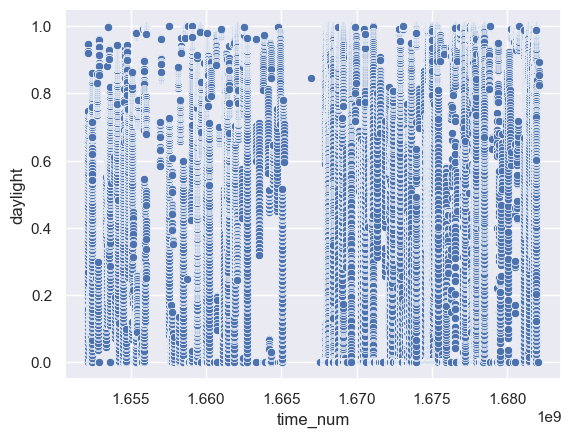

In [58]:
sns.scatterplot(data=df[df["fkLinkSerialId"] == df["fkLinkSerialId"].values[-1] ], x="time_num", y="daylight")

## Add months info linked to season 
Use sin/cos  
to take into account cycle  
For southern hemisphere : (AU) :  rotate + pi  because winter == summer 

In [59]:
df_month = df[["fkReadingsId","timestamp", "lat"]].copy()
df_month["month"] = df_month["timestamp"].copy().astype(np.datetime64).dt.month
df_month["month_cos"] = df_month["month"].apply(cos_norm, args=(12,))
df_month["month_sin"] = df_month["month"].apply(sin_norm, args=(12,))
df_month.loc[df_month["lat"] < 0, "month_cos"] = (
    df_month.loc[df_month["lat"] < 0, "month_cos"].apply(cos_norm, args=(12, True))
)
df_month.loc[df_month["lat"] < 0, "month_sin"] = (
    df_month.loc[df_month["lat"] < 0, "month_sin"].apply(sin_norm, args=(12, True))
)
#df[["timestamp", "month", "month_cos", "month_sin"]]
df_month

fkReadingsId            timestamp        lat  month  month_cos  \
0            2595655  2022-05-07 07:40:48 -33.226616      5  -0.898941   
1            2595657  2022-05-07 07:41:24 -33.226601      5  -0.898941   
2            2595665  2022-05-07 07:43:49 -33.226665      5  -0.898941   
3            2595667  2022-05-07 07:44:25 -33.226707      5  -0.898941   
4            2595675  2022-05-07 07:46:51 -33.226757      5  -0.898941   
...              ...                  ...        ...    ...        ...   
124227       3590602  2023-04-21 15:39:37  43.481373      4  -0.500000   
124228       3590619  2023-04-21 15:42:33  43.481445      4  -0.500000   
124229       3590636  2023-04-21 15:45:29  43.481346      4  -0.500000   
124230       3590705  2023-04-21 15:57:34  43.481396      4  -0.500000   
124231       3590722  2023-04-21 16:00:29  43.481373      4  -0.500000   

        month_sin  
0       -0.258819  
1       -0.258819  
2       -0.258819  
3       -0.258819  
4       -0.258819  
...           ...  
124227   0.866025  
124228   0.866025  
124229   0.866025  
124230   0.866025  
124231   0.866025  

[124232 rows x 6 columns]

In [60]:
df

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124227       3590602  3590602  0XB827EB3B7400  2023-04-21 15:39:37      0   
124228       3590619  3590619  0XB827EB3B7400  2023-04-21 15:42:33      0   
124229       3590636  3590636  0XB827EB3B7400  2023-04-21 15:45:29      0   
124230       3590705  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0   
124231       3590722  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0   

        acceleration  heading direction  msla        lat  ...  country  \
0                  1        0         N    48 -33.226616  ...       au   
1                  1        0         N    28 -33.226601  ...       au   
2                  1        0         N    73 -33.226665  ...       au   
3                  1        0         N    62 -33.226707  ...       au   
4                  1        0         N    34 -33.226757  ...       au   
...              ...      ...       ...   ...        ...  ...      ...   
124227             1        0         N   331  43.481373  ...       ca   
124228             1        0         N   365  43.481445  ...       ca   
124229             1        0         N   349  43.481346  ...       ca   
124230             1        0         N   362  43.481396  ...       ca   
124231             1        0         N   355  43.481373  ...       ca   

       temp_mean temp_min temp_max humi_mean  humi_min  humi_max    time_num  \
0         17.170    17.17    17.17     45.44     45.44     45.44  1651909248   
1         17.550    17.55    17.55     44.66     44.66     44.66  1651909284   
2         17.090    17.09    17.09     45.53     45.53     45.53  1651909429   
3         17.480    17.48    17.48     44.74     44.74     44.74  1651909465   
4         18.550    18.55    18.55     45.62     45.62     45.62  1651909611   
...          ...      ...      ...       ...       ...       ...         ...   
124227    12.000    11.84    12.16     97.63     95.27     99.99  1682091577   
124228    12.090    11.74    12.44     98.53     95.61     99.99  1682091753   
124229    12.010    12.01    12.01     99.99     99.99     99.99  1682091929   
124230    12.040    11.72    12.38     98.91     96.75     99.99  1682092654   
124231    11.445    11.42    11.47     99.99     99.99     99.99  1682092829   

        daylight  b_daylight  
0       0.000000       False  
1       0.000000       False  
2       0.000000       False  
3       0.000000       False  
4       0.000000       False  
...          ...         ...  
124227  0.866164        True  
124228  0.860501        True  
124229  0.854730        True  
124230  0.829832        True  
124231  0.823555        True  

[124232 rows x 47 columns]

In [61]:
df = df.merge(df_month[["fkReadingsId", "month", "month_cos", "month_sin"]], on="fkReadingsId")
df

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124227       3590602  3590602  0XB827EB3B7400  2023-04-21 15:39:37      0   
124228       3590619  3590619  0XB827EB3B7400  2023-04-21 15:42:33      0   
124229       3590636  3590636  0XB827EB3B7400  2023-04-21 15:45:29      0   
124230       3590705  3590705  0XB827EB3B7400  2023-04-21 15:57:34      0   
124231       3590722  3590722  0XB827EB3B7400  2023-04-21 16:00:29      0   

        acceleration  heading direction  msla        lat  ...  temp_max  \
0                  1        0         N    48 -33.226616  ...     17.17   
1                  1        0         N    28 -33.226601  ...     17.55   
2                  1        0         N    73 -33.226665  ...     17.09   
3                  1        0         N    62 -33.226707  ...     17.48   
4                  1        0         N    34 -33.226757  ...     18.55   
...              ...      ...       ...   ...        ...  ...       ...   
124227             1        0         N   331  43.481373  ...     12.16   
124228             1        0         N   365  43.481445  ...     12.44   
124229             1        0         N   349  43.481346  ...     12.01   
124230             1        0         N   362  43.481396  ...     12.38   
124231             1        0         N   355  43.481373  ...     11.47   

       humi_mean humi_min humi_max    time_num  daylight  b_daylight  month  \
0          45.44    45.44    45.44  1651909248  0.000000       False      5   
1          44.66    44.66    44.66  1651909284  0.000000       False      5   
2          45.53    45.53    45.53  1651909429  0.000000       False      5   
3          44.74    44.74    44.74  1651909465  0.000000       False      5   
4          45.62    45.62    45.62  1651909611  0.000000       False      5   
...          ...      ...      ...         ...       ...         ...    ...   
124227     97.63    95.27    99.99  1682091577  0.866164        True      4   
124228     98.53    95.61    99.99  1682091753  0.860501        True      4   
124229     99.99    99.99    99.99  1682091929  0.854730        True      4   
124230     98.91    96.75    99.99  1682092654  0.829832        True      4   
124231     99.99    99.99    99.99  1682092829  0.823555        True      4   

        month_cos  month_sin  
0       -0.898941  -0.258819  
1       -0.898941  -0.258819  
2       -0.898941  -0.258819  
3       -0.898941  -0.258819  
4       -0.898941  -0.258819  
...           ...        ...  
124227  -0.500000   0.866025  
124228  -0.500000   0.866025  
124229  -0.500000   0.866025  
124230  -0.500000   0.866025  
124231  -0.500000   0.866025  

[124232 rows x 50 columns]

## Location

Nb vehicles by country : 

In [62]:
df_nb_veh = df[["country","fkLinkSerialId"]].groupby("country").nunique()
df_nb_veh.reset_index(inplace=True)
df_nb_veh

country  fkLinkSerialId
0      au               1
1      ca               8
2      dk               1
3      ie               1
4      us               4

Text(0.5, 1.0, 'Number of vehicles by country')

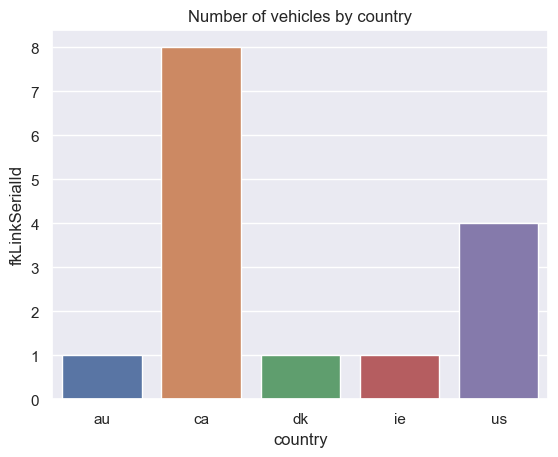

In [63]:
sns.barplot(data=df_nb_veh, x="country", y="fkLinkSerialId")
plt.title("Number of vehicles by country")

In [64]:
df["region"].unique()

array(['AU-NSW', 'CA-QC', 'CA-ON', 'US-NY', None, 'US-PA', 'US-MI',
       'US-IN', 'US-IL', 'US-IA', 'US-VT', 'CA-NB', 'DK-83', 'DK-82',
       'US-MN'], dtype=object)

In [65]:
# locality : a lot of missing values
df["locality"].unique()

array([None, 'Dundas', 'Flamborough', 'Morriston', 'Phillipsburg',
       'Ratzburg', 'Mennonite Corner', 'Amulree', 'Wartburg', 'Kinkora',
       'Lavoie', 'Appleby', 'Ancaster', 'Chameran', 'Zuber Corners',
       'Avonbank', 'Youngsville', 'Glanbrook', 'Lawrence Park',
       'Wesleyville', 'Northwest Harborcreek', 'Brooksdale', 'Fairview',
       'St. Pauls Station', 'Mount Pleasant', 'Willow Grove',
       'Wilmot Centre', 'Schindelsteddle', 'Indian Point', 'Stoney Creek',
       'Homer', 'Niagara', 'Manns Corner', 'Hartsville', 'Independence',
       'West Sparta', 'North Dansville', 'Perkinsville', 'Wallace',
       'Erwin', 'Gang Mills', 'Presho', 'Old Lycoming Township',
       'Kenilworth', 'North Coventry Township', 'West Pikeland Township',
       'South Whitehall Township', 'Upper Macungie Township',
       'Lower Macungie Township', 'Upper Milford Township',
       'Spinnerstown', 'Milford Township', 'Salford Township',
       'Franconia Township', 'Kulpsville', 'Towamenc

In [66]:
df["neighborhood"].unique()

array([None, 'Montréal-Nord', 'Victoria North', 'Rivière-des-Prairies',
       'Anjou', 'Central Frederick', 'Auditorium', 'Southdale',
       'Forest Heights', 'Aldershot', 'Guelph', 'Cambrian Hills',
       'Centennial', 'River Flats', 'Briardean', 'Royal Oak', 'Parklawn',
       'Pioneer Tower East', 'Hidden Valley', 'Vanier', 'Rockway',
       'Alpine', 'Meinzinger Park - Lakeside', 'Laurentian West',
       'Lovell Industrial Park', 'Plains', 'Dynes', 'Longmoor',
       'Pinedale', 'Corporate', 'Palmer', 'Tyandaga', 'Laurentian Hills',
       'Mercier-Ouest', 'Quartier Fatima', 'Quartier Saint-Jude',
       'Northwest Industrial Area', 'Henderson - Sky Acres',
       'Braneida Industrial Park', 'Alberton North', "Duff's Corner",
       'Garner', 'Scenic Woods', 'Ainslie Wood West', 'Ainslie Wood East',
       'Westdale South', 'Dundurn', 'Tansley', 'Fabreville', 'Chomedey',
       'Bordeaux-Cartierville', 'Saint-Laurent', 'Côte-des-Neiges',
       'Notre-Dame-de-Grâce', 'Pointe Sa

In [67]:

df["place"].unique()

array([None, 'Montréal', 'Guelph/Eramosa', 'Guelph', 'Saint-Valentin',
       'Lacolle', 'Champlain', 'Woolwich', 'Charlemagne', 'Breslau',
       'Kitchener', 'Montréal-Est', 'Wilmot', 'New Hamburg', 'Perth East',
       'Tavistock', 'Saint-Blaise-sur-Richelieu', 'Saint-Thomas',
       'Burlington', 'Hamilton', 'Millgrove', 'Freelton', 'Puslinch',
       'Cambridge', 'Sainte-Geneviève-de-Berthier', 'Saint-Cuthbert',
       'Saint-Barthélemy', 'Maskinongé', 'Trois-Rivières',
       'Saint-Étienne-des-Grès', 'Perth South', 'Joliette', 'Saint-Paul',
       'Saint-Bernard-de-Lacolle', 'Repentigny', 'Terrebonne',
       'Stratford', 'East Zorra-Tavistock', 'Longueuil', 'Brossard',
       'Carignan', 'Saint-Jean-sur-Richelieu', 'Saint-Alexandre',
       'Notre-Dame-de-Stanbridge', 'Mitchell', 'West Perth',
       'South Huron', 'Lucan Biddulph', 'North Middlesex',
       'Saint-Édouard', 'Saint-Michel', 'Sebringville', 'Sainte-Clotilde',
       'Saint-Chrysostome', 'Franklin', 'Saint-Antoin

In [68]:
df["place_name"].nunique()

10755

In [69]:
df["place_name"].unique()

array(['St Albans, New South Wales, Australia',
       '5727 Boulevard Industriel, Montréal, Quebec H1G 3J1, Canada',
       '5656 Highway 6, Guelph/Eramosa, Ontario N1H 6J2, Canada', ...,
       '4722 Line 42, Sebringville, Ontario N0K 1X0, Canada',
       '4793 Line 42, Sebringville, Ontario N0K 1X0, Canada',
       '5128 Line 42, Sebringville, Ontario N0K 1X0, Canada'],
      dtype=object)

In [70]:
df["place_type"].unique()

array(['locality', 'address', 'place', 'region', 'postcode'], dtype=object)

In [71]:
df[df["place_type"] == "place"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text" ]]

country place                                place_name region  \
2244        ca  None  Saint-Bernard-de-Lacolle, Quebec, Canada  CA-QC   
3334        ca  None  Saint-Bernard-de-Lacolle, Quebec, Canada  CA-QC   
4053        ca  None  Saint-Bernard-de-Lacolle, Quebec, Canada  CA-QC   
5350        ca  None           Sainte-Clotilde, Quebec, Canada  CA-QC   
13639       ca  None             Chatham-Kent, Ontario, Canada  CA-ON   
...        ...   ...                                       ...    ...   
112852      ca  None                  Morpeth, Ontario, Canada  CA-ON   
122764      ca  None                  Morpeth, Ontario, Canada  CA-ON   
122765      ca  None                  Morpeth, Ontario, Canada  CA-ON   
122768      ca  None                  Morpeth, Ontario, Canada  CA-ON   
122769      ca  None                  Morpeth, Ontario, Canada  CA-ON   

       locality neighborhood postcode                      text  
2244       None         None     None  Saint-Bernard-de-Lacolle  
3334       None         None     None  Saint-Bernard-de-Lacolle  
4053       None         None     None  Saint-Bernard-de-Lacolle  
5350       None         None     None           Sainte-Clotilde  
13639      None         None     None              Chatham-Kent  
...         ...          ...      ...                       ...  
112852     None         None     None                   Morpeth  
122764     None         None     None                   Morpeth  
122765     None         None     None                   Morpeth  
122768     None         None     None                   Morpeth  
122769     None         None     None                   Morpeth  

[228 rows x 8 columns]

In [72]:
df[df["place_type"] == "address"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

country           place  \
1790        ca        Montréal   
1791        ca        Montréal   
2067        ca  Guelph/Eramosa   
2069        ca  Guelph/Eramosa   
2081        ca  Guelph/Eramosa   
...        ...             ...   
124227      ca    Sebringville   
124228      ca    Sebringville   
124229      ca    Sebringville   
124230      ca    Sebringville   
124231      ca    Sebringville   

                                               place_name region locality  \
1790    5727 Boulevard Industriel, Montréal, Quebec H1...  CA-QC     None   
1791    5727 Boulevard Industriel, Montréal, Quebec H1...  CA-QC     None   
2067    5656 Highway 6, Guelph/Eramosa, Ontario N1H 6J...  CA-ON     None   
2069    5656 Highway 6, Guelph/Eramosa, Ontario N1H 6J...  CA-ON     None   
2081    5656 Highway 6, Guelph/Eramosa, Ontario N1H 6J...  CA-ON     None   
...                                                   ...    ...      ...   
124227  4651 145 Road, Sebringville, Ontario N0K 1X0, ...  CA-ON     None   
124228  4651 145 Road, Sebringville, Ontario N0K 1X0, ...  CA-ON     None   
124229  4651 145 Road, Sebringville, Ontario N0K 1X0, ...  CA-ON     None   
124230  4651 145 Road, Sebringville, Ontario N0K 1X0, ...  CA-ON     None   
124231  4651 145 Road, Sebringville, Ontario N0K 1X0, ...  CA-ON     None   

         neighborhood postcode                  text  
1790    Montréal-Nord  H1G 3J1  Boulevard Industriel  
1791    Montréal-Nord  H1G 3J1  Boulevard Industriel  
2067             None  N1H 6J2             Highway 6  
2069             None  N1H 6J2             Highway 6  
2081             None  N1H 6J2             Highway 6  
...               ...      ...                   ...  
124227           None  N0K 1X0              145 Road  
124228           None  N0K 1X0              145 Road  
124229           None  N0K 1X0              145 Road  
124230           None  N0K 1X0              145 Road  
124231           None  N0K 1X0              145 Road  

[112300 rows x 8 columns]

In [73]:
df[df["place_type"] == "postcode"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

country place                place_name region locality neighborhood  \
13585      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13586      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13638      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13641      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13642      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13643      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13644      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
13645      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
18165      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
18166      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
18167      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
19177      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
19178      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
19179      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
36049      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36050      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36051      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36052      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36056      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36057      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36058      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36059      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
36869      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36870      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36874      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
36875      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
36876      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
44413      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
51998      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60224      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60225      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60226      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60228      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60229      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60230      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60231      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60232      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60234      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60235      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60322      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60326      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60327      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60328      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60331      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60332      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
60333      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
63164      ca  None  N0P 1X0, Ontario, Canada  CA-ON     None         None   
63165      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
65884      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
65885      ca  None  N0P 1A0, Ontario, Canada  CA-ON     None         None   
76123      ca  None  N0P 1A0

In [74]:
df[df["place_type"] == "region"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

country place                   place_name region locality  \
9965        us  None  Pennsylvania, United States   None     None   
9966        us  None  Pennsylvania, United States   None     None   
9967        us  None  Pennsylvania, United States   None     None   
9970        us  None  Pennsylvania, United States   None     None   
9971        us  None  Pennsylvania, United States   None     None   
...        ...   ...                          ...    ...      ...   
122754      ca  None              Ontario, Canada   None     None   
122755      ca  None              Ontario, Canada   None     None   
122756      ca  None              Ontario, Canada   None     None   
122760      ca  None              Ontario, Canada   None     None   
122761      ca  None              Ontario, Canada   None     None   

       neighborhood postcode          text  
9965           None     None  Pennsylvania  
9966           None     None  Pennsylvania  
9967           None     None  Pennsylvania  
9970           None     None  Pennsylvania  
9971           None     None  Pennsylvania  
...             ...      ...           ...  
122754         None     None       Ontario  
122755         None     None       Ontario  
122756         None     None       Ontario  
122760         None     None       Ontario  
122761         None     None       Ontario  

[1172 rows x 8 columns]

In [75]:
df[df["place_type"] == "locality"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

country           place                                     place_name  \
0           au            None          St Albans, New South Wales, Australia   
1           au            None          St Albans, New South Wales, Australia   
2           au            None          St Albans, New South Wales, Australia   
3           au            None          St Albans, New South Wales, Australia   
4           au            None          St Albans, New South Wales, Australia   
...        ...             ...                                            ...   
71623       us         Chelsea      Freedom Township, Michigan, United States   
79788       us       Marcellus  Flowerfield Township, Michigan, United States   
108300      us         Russell                 Clare, New York, United States   
108317      us     Harrisville              Pitcairn, New York, United States   
108336      us  Natural Bridge                 Diana, New York, United States   

        region locality neighborhood postcode                  text  
0       AU-NSW     None         None     None             St Albans  
1       AU-NSW     None         None     None             St Albans  
2       AU-NSW     None         None     None             St Albans  
3       AU-NSW     None         None     None             St Albans  
4       AU-NSW     None         None     None             St Albans  
...        ...      ...          ...      ...                   ...  
71623    US-MI     None         None     None      Freedom Township  
79788    US-MI     None         None     None  Flowerfield Township  
108300   US-NY     None         None     None                 Clare  
108317   US-NY     None         None     None              Pitcairn  
108336   US-NY     None         None     None                 Diana  

[10475 rows x 8 columns]

### Imputation location data:

In [76]:
df_imp = df.copy()
for col in df["place_type"].unique():
    df_imp.loc[df["place_type"] == col, col] = df_imp.loc[df["place_type"] == col, "text"]

df_imp[df_imp["place_type"] == "locality"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

country           place                                     place_name  \
0           au            None          St Albans, New South Wales, Australia   
1           au            None          St Albans, New South Wales, Australia   
2           au            None          St Albans, New South Wales, Australia   
3           au            None          St Albans, New South Wales, Australia   
4           au            None          St Albans, New South Wales, Australia   
...        ...             ...                                            ...   
71623       us         Chelsea      Freedom Township, Michigan, United States   
79788       us       Marcellus  Flowerfield Township, Michigan, United States   
108300      us         Russell                 Clare, New York, United States   
108317      us     Harrisville              Pitcairn, New York, United States   
108336      us  Natural Bridge                 Diana, New York, United States   

        region              locality neighborhood postcode  \
0       AU-NSW             St Albans         None     None   
1       AU-NSW             St Albans         None     None   
2       AU-NSW             St Albans         None     None   
3       AU-NSW             St Albans         None     None   
4       AU-NSW             St Albans         None     None   
...        ...                   ...          ...      ...   
71623    US-MI      Freedom Township         None     None   
79788    US-MI  Flowerfield Township         None     None   
108300   US-NY                 Clare         None     None   
108317   US-NY              Pitcairn         None     None   
108336   US-NY                 Diana         None     None   

                        text  
0                  St Albans  
1                  St Albans  
2                  St Albans  
3                  St Albans  
4                  St Albans  
...                      ...  
71623       Freedom Township  
79788   Flowerfield Township  
108300                 Clare  
108317              Pitcairn  
108336                 Diana  

[10475 rows x 8 columns]

In [77]:
nb_missing = get_missing(df)

missing data : 
region            1172
temp_mean         2717
temp_min          2717
temp_max          2717
place            11917
accuracy         11932
postcode         11997
wind_gust        24172
neighborhood    112277
locality        116051
rain            117074
snow            117678
dtype: int64

on 124232 samples


In [78]:
nb_missing_imp = get_missing(df_imp)

missing data : 
temp_mean         2717
temp_min          2717
temp_max          2717
place            11689
address          11932
accuracy         11932
postcode         11940
wind_gust        24172
locality        105576
neighborhood    112277
rain            117074
snow            117678
dtype: int64

on 124232 samples


In [79]:
df[df["place_type"] == "locality"]["locality"]

0         None
1         None
2         None
3         None
4         None
          ... 
71623     None
79788     None
108300    None
108317    None
108336    None
Name: locality, Length: 10475, dtype: object

In [80]:
df_imp[df_imp["place_type"] == "locality"]["locality"]

0                    St Albans
1                    St Albans
2                    St Albans
3                    St Albans
4                    St Albans
                  ...         
71623         Freedom Township
79788     Flowerfield Township
108300                   Clare
108317                Pitcairn
108336                   Diana
Name: locality, Length: 10475, dtype: object

In [81]:
df_imp["region"].nunique()

18

### add lat/long mean for each region

In [82]:
df_reg = df_imp.groupby("region").agg(
    lat_reg = ("lat", "mean"),
    long_reg = ("long", "mean")
)
df_reg.reset_index(inplace=True)
df_reg

region    lat_reg    long_reg
0          AU-NSW -33.226641  150.961237
1           CA-NB  47.245468  -68.718170
2           CA-ON  43.472742  -80.633733
3           CA-QC  45.923124  -72.649528
4   County Dublin  53.448845   -6.032892
5           DK-82  56.246979   10.136665
6           DK-83  55.729118    9.134009
7            Ohio  42.212363  -81.234405
8         Ontario  42.240119  -81.728790
9    Pennsylvania  42.230088  -80.050480
10          US-IA  41.723521  -91.492705
11          US-IL  41.482478  -88.654286
12          US-IN  41.296839  -86.762593
13          US-MI  42.317584  -85.121884
14          US-MN  44.128008  -93.257519
15          US-NY  43.450219  -77.102604
16          US-PA  41.546299  -78.470563
17          US-VT  45.004970  -72.640175

In [83]:
df_imp = df_imp.merge(df_reg, on="region")
df_imp[["region", "lat_reg", "long_reg"]]

region    lat_reg    long_reg
0       AU-NSW -33.226641  150.961237
1       AU-NSW -33.226641  150.961237
2       AU-NSW -33.226641  150.961237
3       AU-NSW -33.226641  150.961237
4       AU-NSW -33.226641  150.961237
...        ...        ...         ...
124227   US-MN  44.128008  -93.257519
124228   US-MN  44.128008  -93.257519
124229   US-MN  44.128008  -93.257519
124230   US-MN  44.128008  -93.257519
124231   US-MN  44.128008  -93.257519

[124232 rows x 3 columns]

In [84]:
df.shape

(124232, 50)

In [85]:
df_imp.shape

(124232, 53)

In [86]:
df = df_imp

<AxesSubplot: xlabel='lat', ylabel='long'>

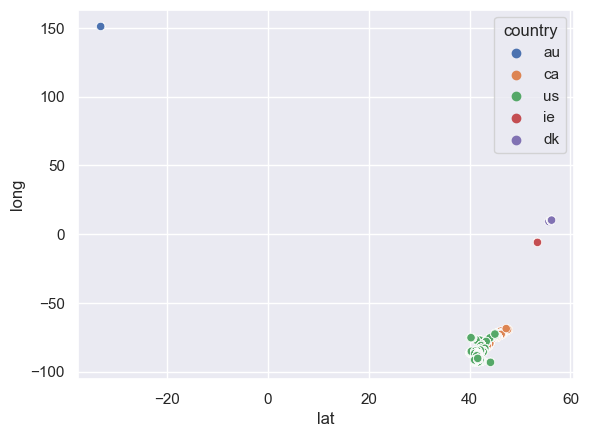

In [87]:
sns.scatterplot(data=df, x="lat", y="long", hue="country")

<AxesSubplot: xlabel='lat', ylabel='country'>

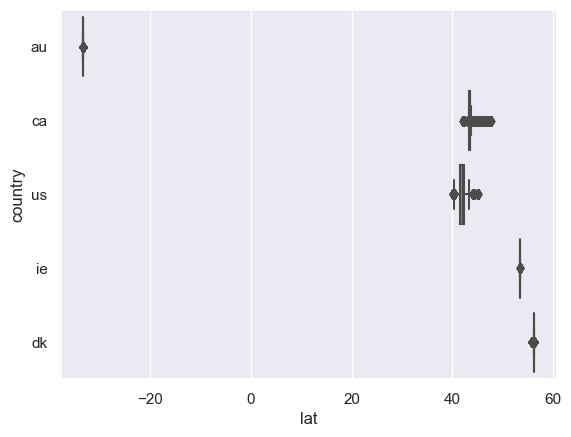

In [88]:
sns.boxplot(data=df, y="country", x="lat")

## Weather imputation

wind_gust / rain / snow is NaN => 0
 

In [89]:
df.loc[df["wind_gust"].isna(), "wind_gust"] = 0
df.loc[df["rain"].isna(), "rain"] = 0
df.loc[df["snow"].isna(), "snow"] = 0

In [90]:
nb_missing = get_missing(df)

missing data : 
temp_max          2717
temp_min          2717
temp_mean         2717
place            11689
accuracy         11932
address          11932
postcode         11940
locality        105576
neighborhood    112277
dtype: int64

on 124232 samples


### Wind / speed
Calculate sin/cos of wind and delta angle with vehicle direction

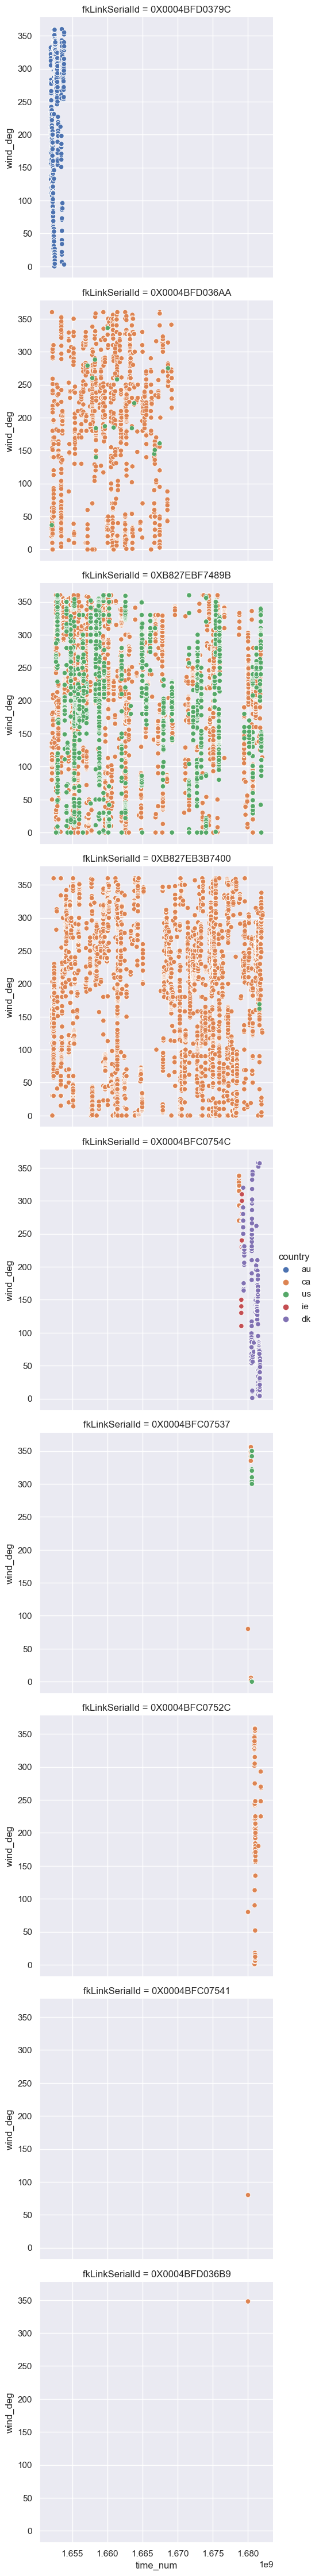

In [91]:
sns.relplot(data=df, x="time_num", y="wind_deg", hue="country", row="fkLinkSerialId")

In [92]:
df_wind = df.copy()[["fkReadingsId", "wind_deg", "heading", "speed", "wind_speed"]]
df_wind["wind_deg_sin"] = df_wind["wind_deg"].apply(sin_norm, args=(360,))
df_wind["wind_deg_cos"] = df_wind["wind_deg"].apply(cos_norm, args=(360,))
df_wind

fkReadingsId  wind_deg  heading  speed  wind_speed  wind_deg_sin  \
0            2595655       322        0      0        1.68     -0.615661   
1            2595657       322        0      0        1.68     -0.615661   
2            2595665       322        0      0        1.68     -0.615661   
3            2595667       322        0      0        1.68     -0.615661   
4            2595675       322        0      0        1.68     -0.615661   
...              ...       ...      ...    ...         ...           ...   
124227       3497999       300        0      0        2.57     -0.866025   
124228       3498005       300        0      0        2.57     -0.866025   
124229       3498009       300        0      0        2.57     -0.866025   
124230       3498017       300        0      1        2.57     -0.866025   
124231       3498019       300        0      0        2.57     -0.866025   

        wind_deg_cos  
0           0.788011  
1           0.788011  
2           0.788011  
3           0.788011  
4           0.788011  
...              ...  
124227      0.500000  
124228      0.500000  
124229      0.500000  
124230      0.500000  
124231      0.500000  

[124232 rows x 7 columns]

In [93]:
df_wind["wind_deg_sin"] = df_wind["wind_deg"].apply(sin_norm, args=(360,))
df_wind["wind_deg_cos"] = df_wind["wind_deg"].apply(cos_norm, args=(360,))

<AxesSubplot: xlabel='heading'>

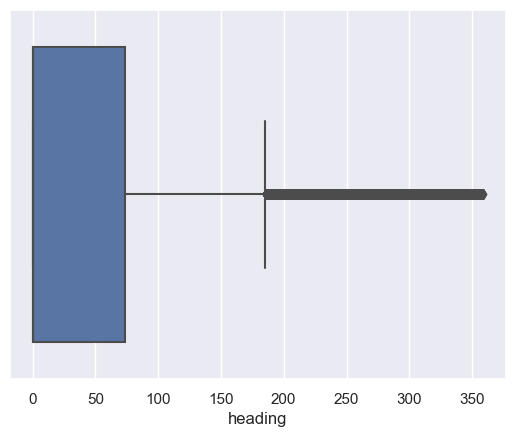

In [94]:
sns.boxplot(data=df,  x="heading")

In [95]:
df_wind["heading_sin"] = df_wind["heading"].apply(sin_norm, args=(360,))
df_wind["heading_cos"] = df_wind["heading"].apply(cos_norm, args=(360,))

In [96]:
math.cos((45-315)/360*2*math.pi)

-1.8369701987210297e-16

For heading, we only take the cos of the delta angle : heading angle - wind angle  

If same direction, high airflow on the vehicule : speed + wind (cos 0 = 1)  
If opposite direction, airflow is very low   (cos 180° = -1)  
if on the side, no impact close to zero  (cos 90° = 0)  


In [97]:
df_wind["delta_angle"] = df_wind["wind_deg"] - df_wind["heading"]
df_wind["delta_angle_cos"] =df_wind["delta_angle"].apply(cos_norm, args=(360,))
df_wind["delta_angle_sin"] =df_wind["delta_angle"].apply(sin_norm, args=(360,))
df_wind["wind_rel_cos"] = - df_wind["speed"]*1000/3600 - df_wind["delta_angle_cos"]*df_wind["wind_speed"]
df_wind["wind_rel_sin"] = - df_wind["delta_angle_sin"]*df_wind["wind_speed"]
df_wind

fkReadingsId  wind_deg  heading  speed  wind_speed  wind_deg_sin  \
0            2595655       322        0      0        1.68     -0.615661   
1            2595657       322        0      0        1.68     -0.615661   
2            2595665       322        0      0        1.68     -0.615661   
3            2595667       322        0      0        1.68     -0.615661   
4            2595675       322        0      0        1.68     -0.615661   
...              ...       ...      ...    ...         ...           ...   
124227       3497999       300        0      0        2.57     -0.866025   
124228       3498005       300        0      0        2.57     -0.866025   
124229       3498009       300        0      0        2.57     -0.866025   
124230       3498017       300        0      1        2.57     -0.866025   
124231       3498019       300        0      0        2.57     -0.866025   

        wind_deg_cos  heading_sin  heading_cos  delta_angle  delta_angle_cos  \
0           0.788011          0.0          1.0          322         0.788011   
1           0.788011          0.0          1.0          322         0.788011   
2           0.788011          0.0          1.0          322         0.788011   
3           0.788011          0.0          1.0          322         0.788011   
4           0.788011          0.0          1.0          322         0.788011   
...              ...          ...          ...          ...              ...   
124227      0.500000          0.0          1.0          300         0.500000   
124228      0.500000          0.0          1.0          300         0.500000   
124229      0.500000          0.0          1.0          300         0.500000   
124230      0.500000          0.0          1.0          300         0.500000   
124231      0.500000          0.0          1.0          300         0.500000   

        delta_angle_sin  wind_rel_cos  wind_rel_sin  
0             -0.615661     -1.323858      1.034311  
1             -0.615661     -1.323858      1.034311  
2             -0.615661     -1.323858      1.034311  
3             -0.615661     -1.323858      1.034311  
4             -0.615661     -1.323858      1.034311  
...                 ...           ...           ...  
124227        -0.866025     -1.285000      2.225685  
124228        -0.866025     -1.285000      2.225685  
124229        -0.866025     -1.285000      2.225685  
124230        -0.866025     -1.562778      2.225685  
124231        -0.866025     -1.285000      2.225685  

[124232 rows x 14 columns]

In [98]:
df_wind["wind_rel_cos"]**2 + df_wind["wind_rel_sin"]**2 - df_wind["wind_speed"]**2

0         4.440892e-16
1         4.440892e-16
2         4.440892e-16
3         4.440892e-16
4         4.440892e-16
              ...     
124227   -8.881784e-16
124228   -8.881784e-16
124229   -8.881784e-16
124230    7.910494e-01
124231   -8.881784e-16
Length: 124232, dtype: float64

In [99]:
df = df.merge(
    df_wind[
        ["fkReadingsId", "wind_deg_cos", "wind_deg_sin",  "heading_cos", 
         "heading_sin", "wind_rel_cos", "wind_rel_sin"]
    ], 
    on="fkReadingsId"
)
df

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124227       3497999  3497999  0X0004BFC07537  2023-04-04 00:15:34      0   
124228       3498005  3498005  0X0004BFC07537  2023-04-04 00:16:30      0   
124229       3498009  3498009  0X0004BFC07537  2023-04-04 00:17:08      0   
124230       3498017  3498017  0X0004BFC07537  2023-04-04 00:18:23      1   
124231       3498019  3498019  0X0004BFC07537  2023-04-04 00:18:42      0   

        acceleration  heading direction  msla        lat  ...  month_sin  \
0                  1        0         N    48 -33.226616  ...  -0.258819   
1                  1        0         N    28 -33.226601  ...  -0.258819   
2                  1        0         N    73 -33.226665  ...  -0.258819   
3                  1        0         N    62 -33.226707  ...  -0.258819   
4                  1        0         N    34 -33.226757  ...  -0.258819   
...              ...      ...       ...   ...        ...  ...        ...   
124227             1        0         N   286  44.127907  ...   0.866025   
124228             1        0         N   286  44.127914  ...   0.866025   
124229             1        0         N   287  44.127914  ...   0.866025   
124230             1        0         N   270  44.128029  ...   0.866025   
124231             1        0         N   271  44.128052  ...   0.866025   

            address    lat_reg    long_reg wind_deg_cos  wind_deg_sin  \
0               NaN -33.226641  150.961237     0.788011     -0.615661   
1               NaN -33.226641  150.961237     0.788011     -0.615661   
2               NaN -33.226641  150.961237     0.788011     -0.615661   
3               NaN -33.226641  150.961237     0.788011     -0.615661   
4               NaN -33.226641  150.961237     0.788011     -0.615661   
...             ...        ...         ...          ...           ...   
124227  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124228  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124229  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124230  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124231  Runway Road  44.128008  -93.257519     0.500000     -0.866025   

        heading_cos  heading_sin  wind_rel_cos  wind_rel_sin  
0               1.0          0.0     -1.323858      1.034311  
1               1.0          0.0     -1.323858      1.034311  
2               1.0          0.0     -1.323858      1.034311  
3               1.0          0.0     -1.323858      1.034311  
4               1.0          0.0     -1.323858      1.034311  
...             ...          ...           ...           ...  
124227          1.0          0.0     -1.285000      2.225685  
124228          1.0          0.0     -1.285000      2.225685  
124229          1.0          0.0     -1.285000      2.225685  
124230          1.0          0.0     -1.562778      2.225685  
124231          1.0          0.0     -1.285000      2.225685  

[124232 rows x 59 columns]

## Drop Nan temp/humi

In [100]:
nb_missing

temp_max          2717
temp_min          2717
temp_mean         2717
place            11689
accuracy         11932
address          11932
postcode         11940
locality        105576
neighborhood    112277
dtype: int64

In [101]:
df.loc[df["temp_mean"].isna(), "country"].unique()

array(['ca', 'us', 'dk'], dtype=object)

In [102]:
df.loc[df["temp_mean"].isna(), "fkLinkSerialId"].unique()

array(['0X0004BFD036AA', '0XB827EB3B7400', '0XB827EBF7489B',
       '0X0004BFC0754C'], dtype=object)

In [103]:
df = df.dropna(subset=["temp_mean"])
nb_missing = get_missing(df)

missing data : 
place            11689
address          11927
accuracy         11927
postcode         11934
locality        102923
neighborhood    109675
dtype: int64

on 121515 samples


## Find correlations between geolocation, external weather, timestamp, and internal microclimate data. How are these pillars interconnected?

In [104]:
df

fkReadingsId     pkId  fkLinkSerialId            timestamp  speed  \
0            2595655  2595655  0X0004BFD0379C  2022-05-07 07:40:48      0   
1            2595657  2595657  0X0004BFD0379C  2022-05-07 07:41:24      0   
2            2595665  2595665  0X0004BFD0379C  2022-05-07 07:43:49      0   
3            2595667  2595667  0X0004BFD0379C  2022-05-07 07:44:25      0   
4            2595675  2595675  0X0004BFD0379C  2022-05-07 07:46:51      0   
...              ...      ...             ...                  ...    ...   
124227       3497999  3497999  0X0004BFC07537  2023-04-04 00:15:34      0   
124228       3498005  3498005  0X0004BFC07537  2023-04-04 00:16:30      0   
124229       3498009  3498009  0X0004BFC07537  2023-04-04 00:17:08      0   
124230       3498017  3498017  0X0004BFC07537  2023-04-04 00:18:23      1   
124231       3498019  3498019  0X0004BFC07537  2023-04-04 00:18:42      0   

        acceleration  heading direction  msla        lat  ...  month_sin  \
0                  1        0         N    48 -33.226616  ...  -0.258819   
1                  1        0         N    28 -33.226601  ...  -0.258819   
2                  1        0         N    73 -33.226665  ...  -0.258819   
3                  1        0         N    62 -33.226707  ...  -0.258819   
4                  1        0         N    34 -33.226757  ...  -0.258819   
...              ...      ...       ...   ...        ...  ...        ...   
124227             1        0         N   286  44.127907  ...   0.866025   
124228             1        0         N   286  44.127914  ...   0.866025   
124229             1        0         N   287  44.127914  ...   0.866025   
124230             1        0         N   270  44.128029  ...   0.866025   
124231             1        0         N   271  44.128052  ...   0.866025   

            address    lat_reg    long_reg wind_deg_cos  wind_deg_sin  \
0               NaN -33.226641  150.961237     0.788011     -0.615661   
1               NaN -33.226641  150.961237     0.788011     -0.615661   
2               NaN -33.226641  150.961237     0.788011     -0.615661   
3               NaN -33.226641  150.961237     0.788011     -0.615661   
4               NaN -33.226641  150.961237     0.788011     -0.615661   
...             ...        ...         ...          ...           ...   
124227  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124228  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124229  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124230  Runway Road  44.128008  -93.257519     0.500000     -0.866025   
124231  Runway Road  44.128008  -93.257519     0.500000     -0.866025   

        heading_cos  heading_sin  wind_rel_cos  wind_rel_sin  
0               1.0          0.0     -1.323858      1.034311  
1               1.0          0.0     -1.323858      1.034311  
2               1.0          0.0     -1.323858      1.034311  
3               1.0          0.0     -1.323858      1.034311  
4               1.0          0.0     -1.323858      1.034311  
...             ...          ...           ...           ...  
124227          1.0          0.0     -1.285000      2.225685  
124228          1.0          0.0     -1.285000      2.225685  
124229          1.0          0.0     -1.285000      2.225685  
124230          1.0          0.0     -1.562778      2.225685  
124231          1.0          0.0     -1.285000      2.225685  

[121515 rows x 59 columns]

In [105]:

df_test = df.copy()[
    ["temp_mean", "humi_mean", "temp", "humidity","feels_like", "pressure", 
    "clouds", "visibility", "wind_speed", "speed",
    "wind_gust", "wind_deg_cos", "wind_deg_sin", "wind_rel_cos", "wind_rel_sin", 
    "heading_cos", "heading_sin",
    "rain", "snow", "daylight", "month_cos", "month_sin", "msla",
    "lat", "long", "lat_reg", "long_reg"]
]

#corr_mat = df.corr().stack().reset_index(name="correlation")
df_test

temp_mean  humi_mean  temp  humidity  feels_like  pressure  clouds  \
0          17.170     45.440  7.73        70        6.86      1024      94   
1          17.550     44.660  7.73        70        6.86      1024      94   
2          17.090     45.530  7.73        70        6.86      1024      94   
3          17.480     44.740  7.73        70        6.86      1024      94   
4          18.550     45.620  7.73        70        6.86      1024      94   
...           ...        ...   ...       ...         ...       ...     ...   
124227     21.745     28.215  1.11        81       -1.78      1013     100   
124228     21.800     27.760  1.11        81       -1.78      1013     100   
124229     21.870     27.850  1.11        81       -1.78      1013     100   
124230     21.740     28.130  1.11        81       -1.78      1013     100   
124231     21.775     28.155  1.11        81       -1.78      1013     100   

        visibility  wind_speed  speed  ...  rain  snow  daylight  month_cos  \
0            10000        1.68      0  ...   0.0   0.0       0.0  -0.898941   
1            10000        1.68      0  ...   0.0   0.0       0.0  -0.898941   
2            10000        1.68      0  ...   0.0   0.0       0.0  -0.898941   
3            10000        1.68      0  ...   0.0   0.0       0.0  -0.898941   
4            10000        1.68      0  ...   0.0   0.0       0.0  -0.898941   
...            ...         ...    ...  ...   ...   ...       ...        ...   
124227       10000        2.57      0  ...   0.0   0.0       0.0  -0.500000   
124228       10000        2.57      0  ...   0.0   0.0       0.0  -0.500000   
124229       10000        2.57      0  ...   0.0   0.0       0.0  -0.500000   
124230       10000        2.57      1  ...   0.0   0.0       0.0  -0.500000   
124231       10000        2.57      0  ...   0.0   0.0       0.0  -0.500000   

        month_sin  msla        lat        long    lat_reg    long_reg  
0       -0.258819    48 -33.226616  150.961105 -33.226641  150.961237  
1       -0.258819    28 -33.226601  150.961136 -33.226641  150.961237  
2       -0.258819    73 -33.226665  150.961136 -33.226641  150.961237  
3       -0.258819    62 -33.226707  150.961105 -33.226641  150.961237  
4       -0.258819    34 -33.226757  150.961075 -33.226641  150.961237  
...           ...   ...        ...         ...        ...         ...  
124227   0.866025   286  44.127907  -93.257469  44.128008  -93.257519  
124228   0.866025   286  44.127914  -93.257469  44.128008  -93.257519  
124229   0.866025   287  44.127914  -93.257454  44.128008  -93.257519  
124230   0.866025   270  44.128029  -93.257454  44.128008  -93.257519  
124231   0.866025   271  44.128052  -93.257454  44.128008  -93.257519  

[121515 rows x 27 columns]

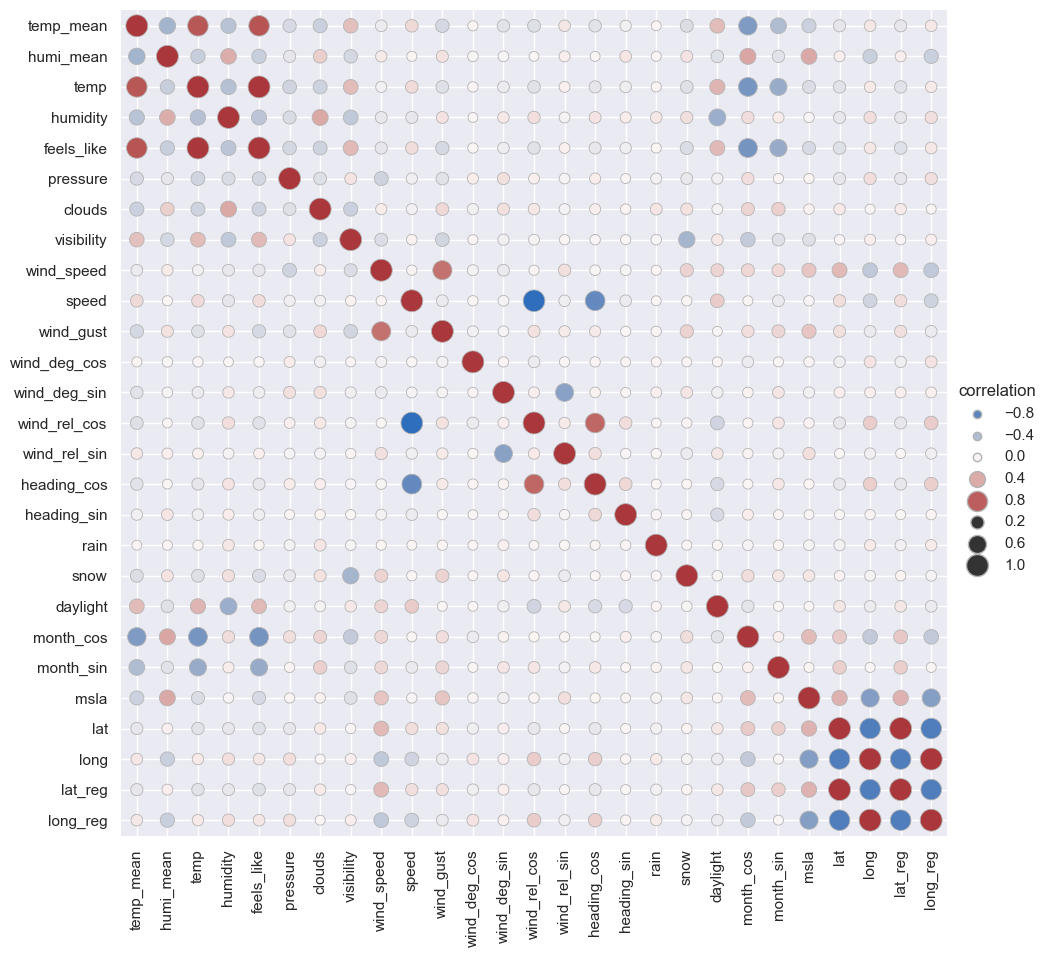

In [132]:
# Compute a correlation matrix and convert to long-form
corr_mat = df_test.corr().stack().reset_index(name="correlation")
# Draw each cell as a scatter point with varying size and color
"""g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)"""

g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size=np.abs(corr_mat["correlation"]),
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250))

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

- Of course, external temperature increases internal temperature
- Daylight increases internal & external temperatures
- Altitude increases internal humidity & wind speed 
- Winter months decrease internal & external temperatures but increase internal humidity
- More wind at high latitudes
- External humidity increases internal humidity
- Clouds decrease temperature but increase humidity
- Visibility increase temperature but decrease humidity
- Maybe speed slightly increase inernal temperature
- Perhaps the relative headwind (wind_rel_cos) slightly lowers the internal temperature




## How does this interconnectedness influence the risk of dangerous temperatures or humidity?

### Increase temperature ?
temp external, daylight, visibility, month_cos, speed

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_451/88033388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_risk"] = df["temp_mean"] > 25


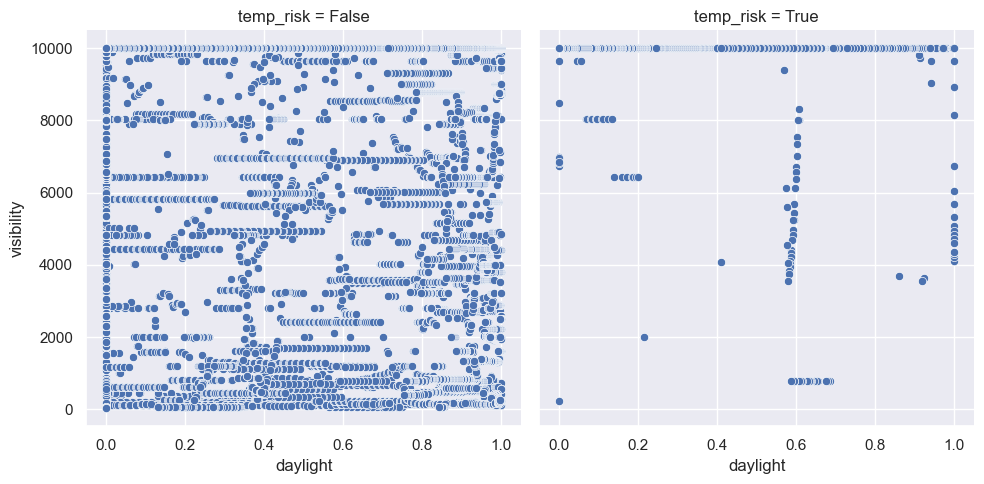

In [107]:
# daylight, visibility, month_cos, speed
df["temp_risk"] = df["temp_mean"] > 25
sns.relplot(data=df, x="daylight", y="visibility", col="temp_risk")

In [151]:
df["temp_ext_high"] = df["temp"] > 25


/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_451/2573202368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_ext_high"] = df["temp"] > 25


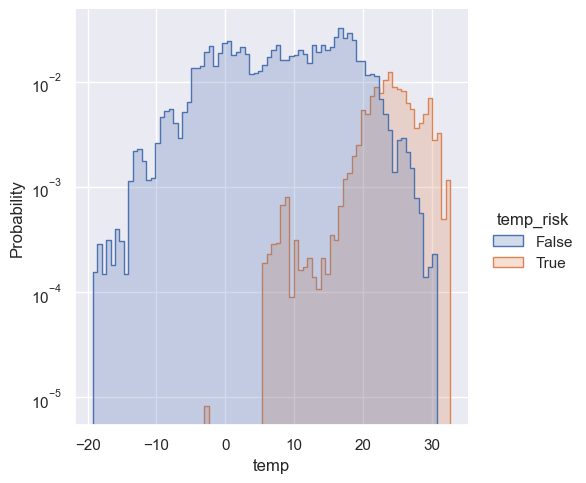

In [285]:
sns.displot(df, x="temp", hue="temp_risk", element="step",
             stat="probability", log_scale=(False,True))

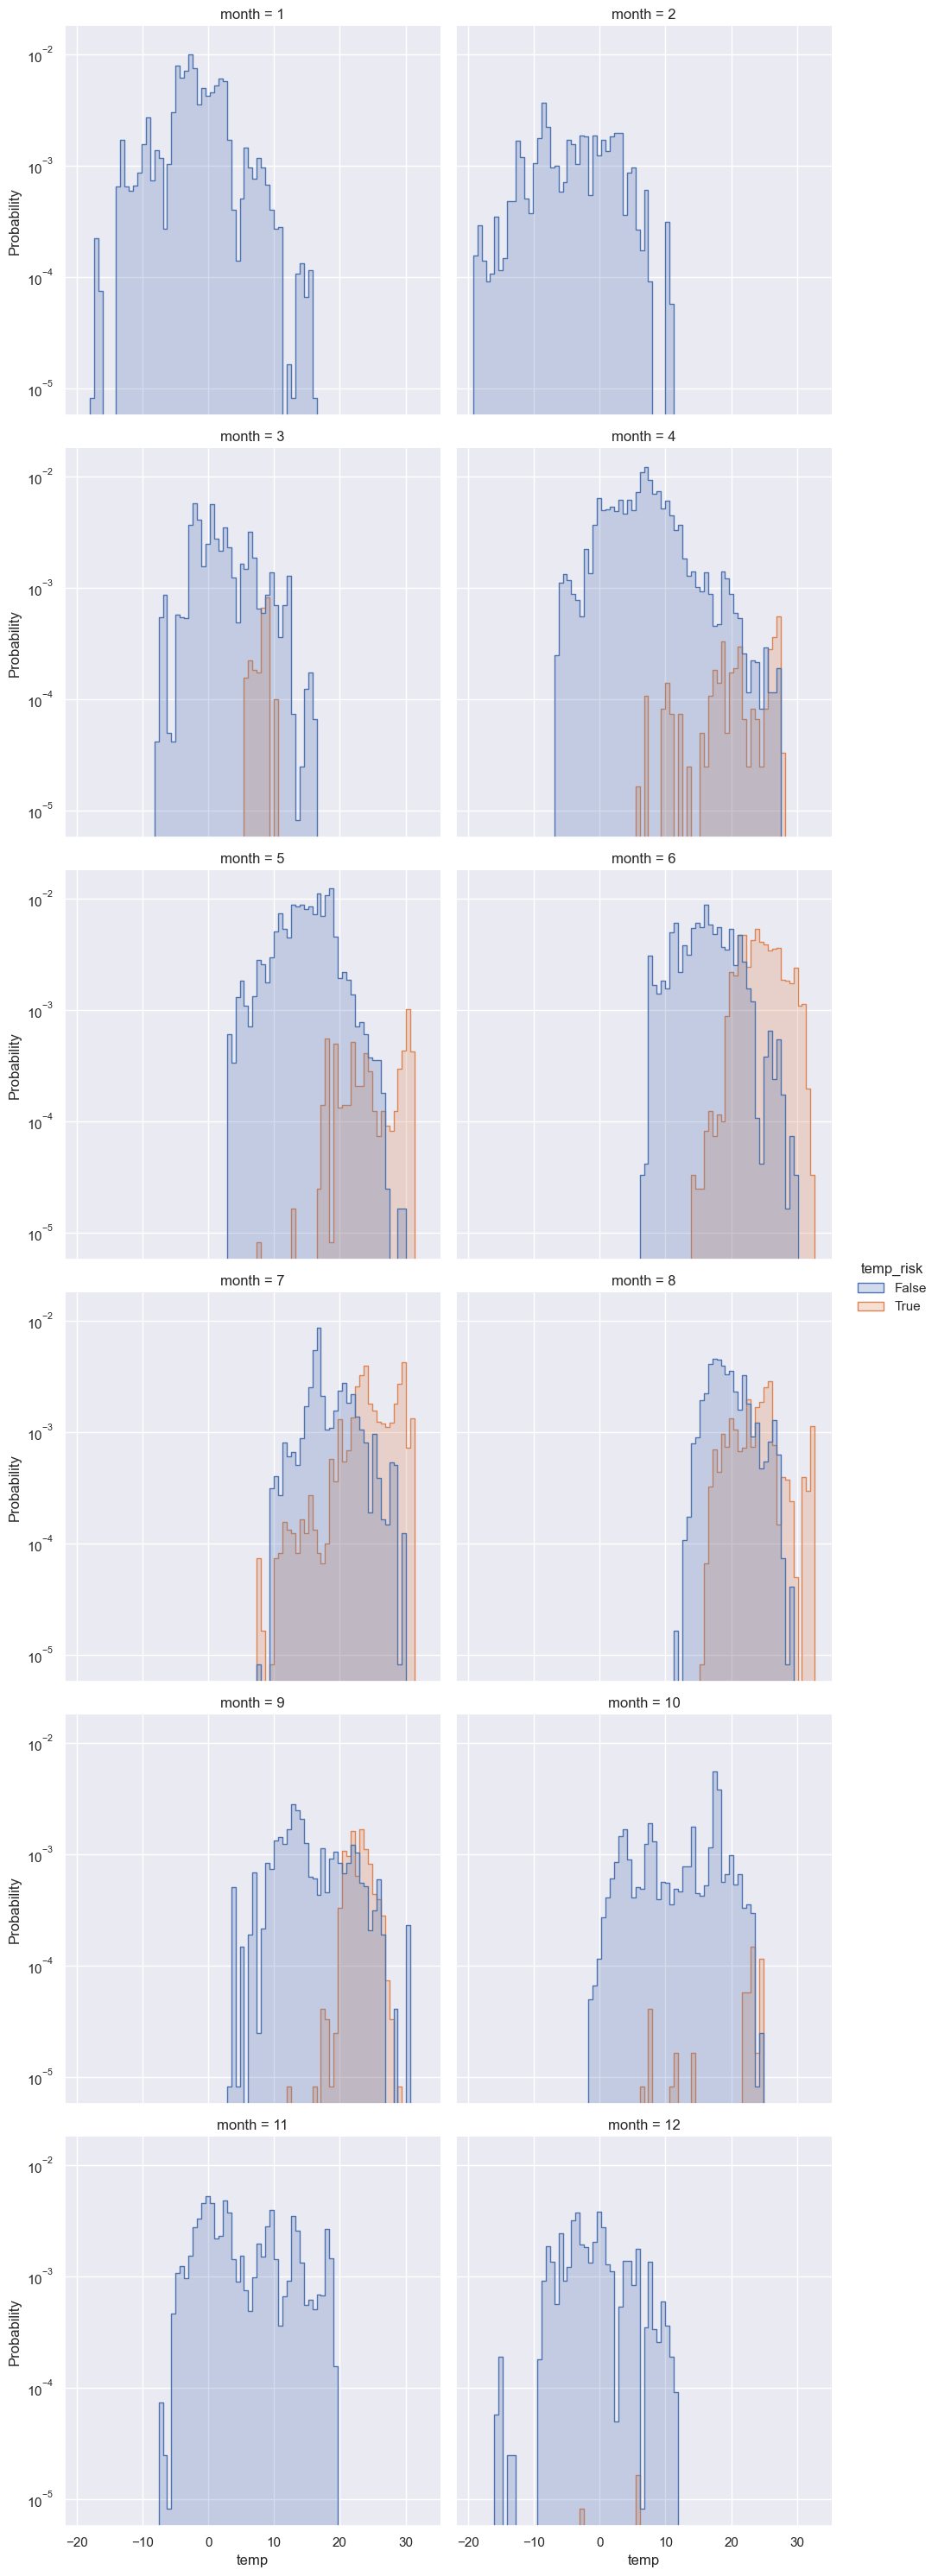

In [154]:
sns.displot(df, x="temp", hue="temp_risk", col="month", element="step",
             col_wrap=2, stat="probability", log_scale=(False,True))

Higher external temperature => Higher risk of internal temperature

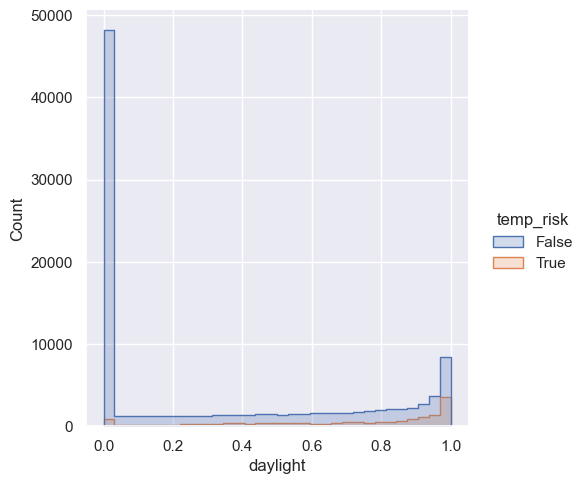

In [108]:
sns.displot(df, x="daylight", hue="temp_risk", element="step")

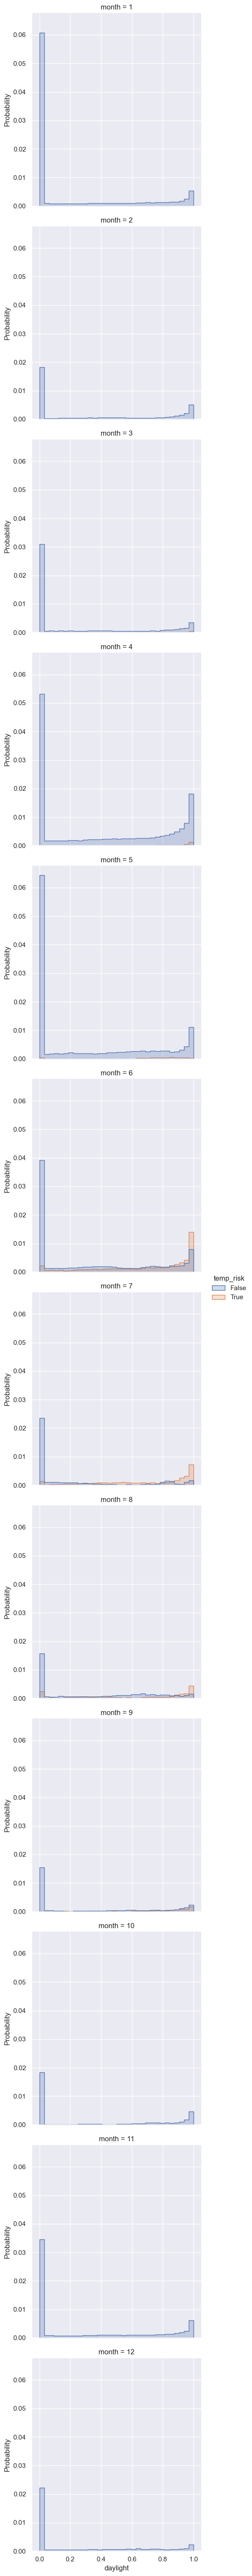

In [143]:
sns.displot(df, x="daylight", hue="temp_risk", row="month", stat="probability", element="step")

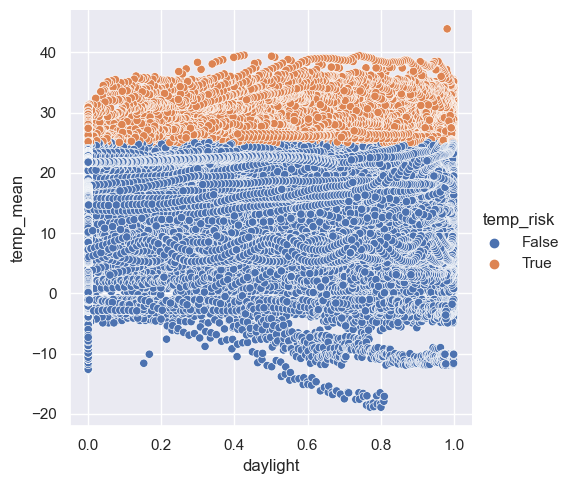

In [110]:
sns.relplot(data=df, x="daylight", y="temp_mean", hue="temp_risk")

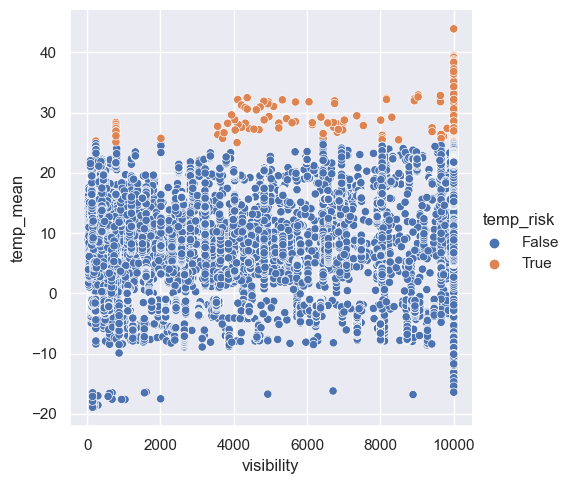

In [111]:
sns.relplot(data=df, x="visibility", y="temp_mean", hue="temp_risk")

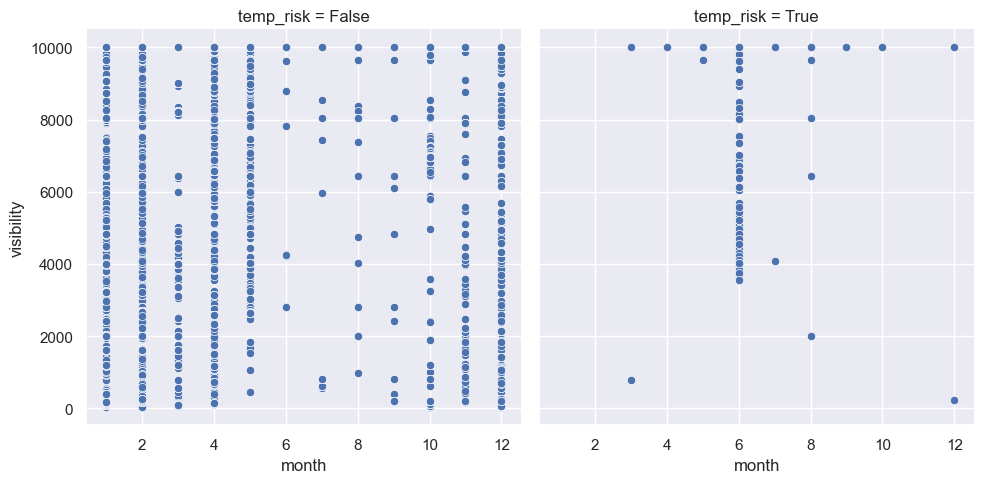

In [144]:
sns.relplot(data=df, x="month", y="visibility", col="temp_risk") 

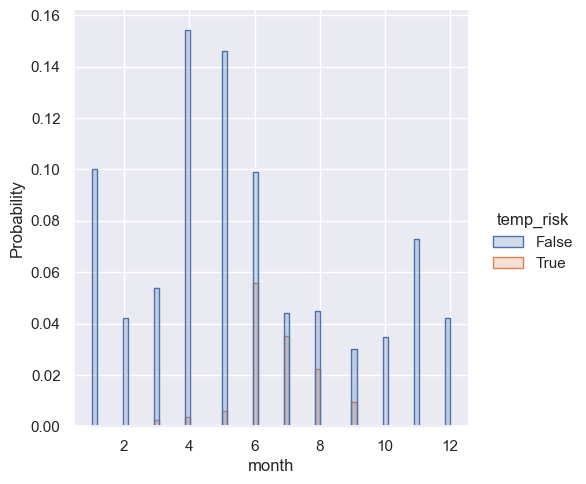

In [145]:
sns.displot(df, x="month", hue="temp_risk", stat="probability", element="step")

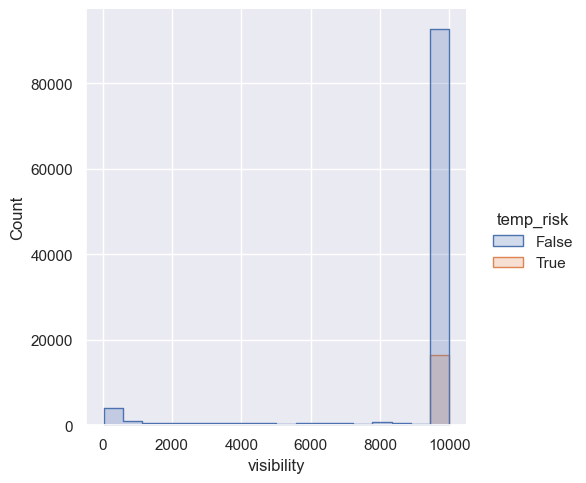

In [114]:
sns.displot(df, x="visibility", hue="temp_risk", element="step")

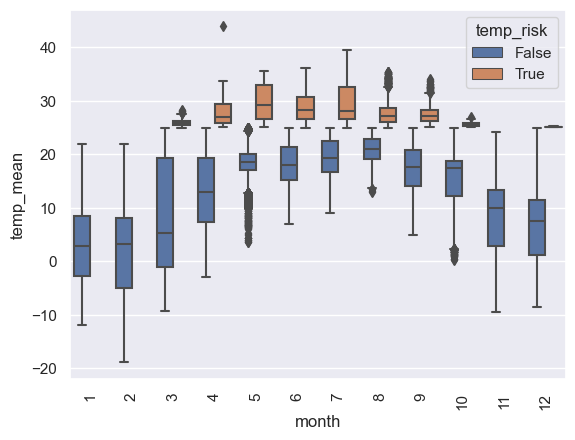

In [146]:
g = sns.boxplot(data=df, x="month", y="temp_mean", hue="temp_risk")
for label in g.get_xticklabels():
    label.set_rotation(90)

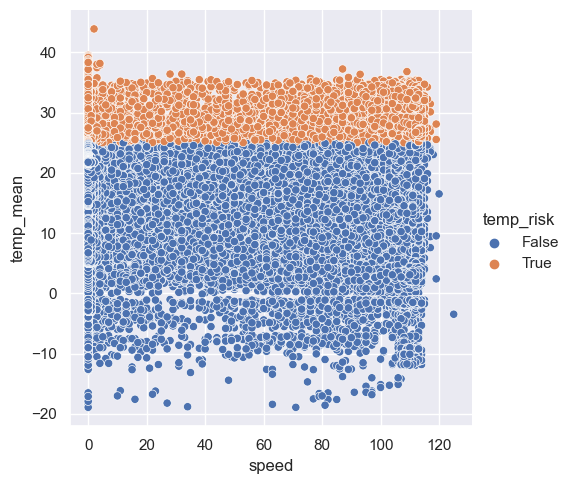

In [116]:


sns.relplot(data=df, x="speed", y="temp_mean", hue="temp_risk") 


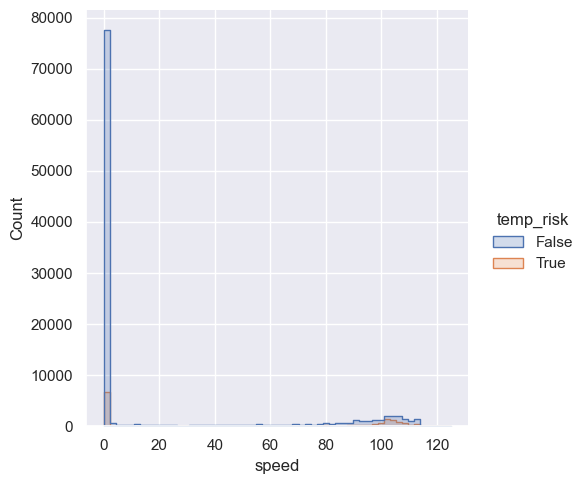

In [117]:
sns.displot(df, x="speed", hue="temp_risk", element="step")

In [118]:
df["visibility"].nunique()

1677

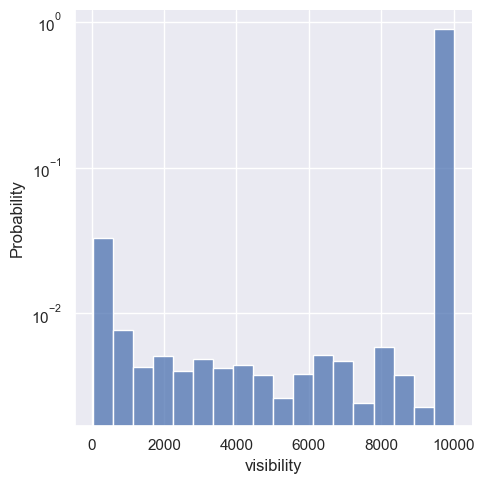

In [135]:
sns.displot(df, x="visibility", stat="probability", log_scale=(False,True))

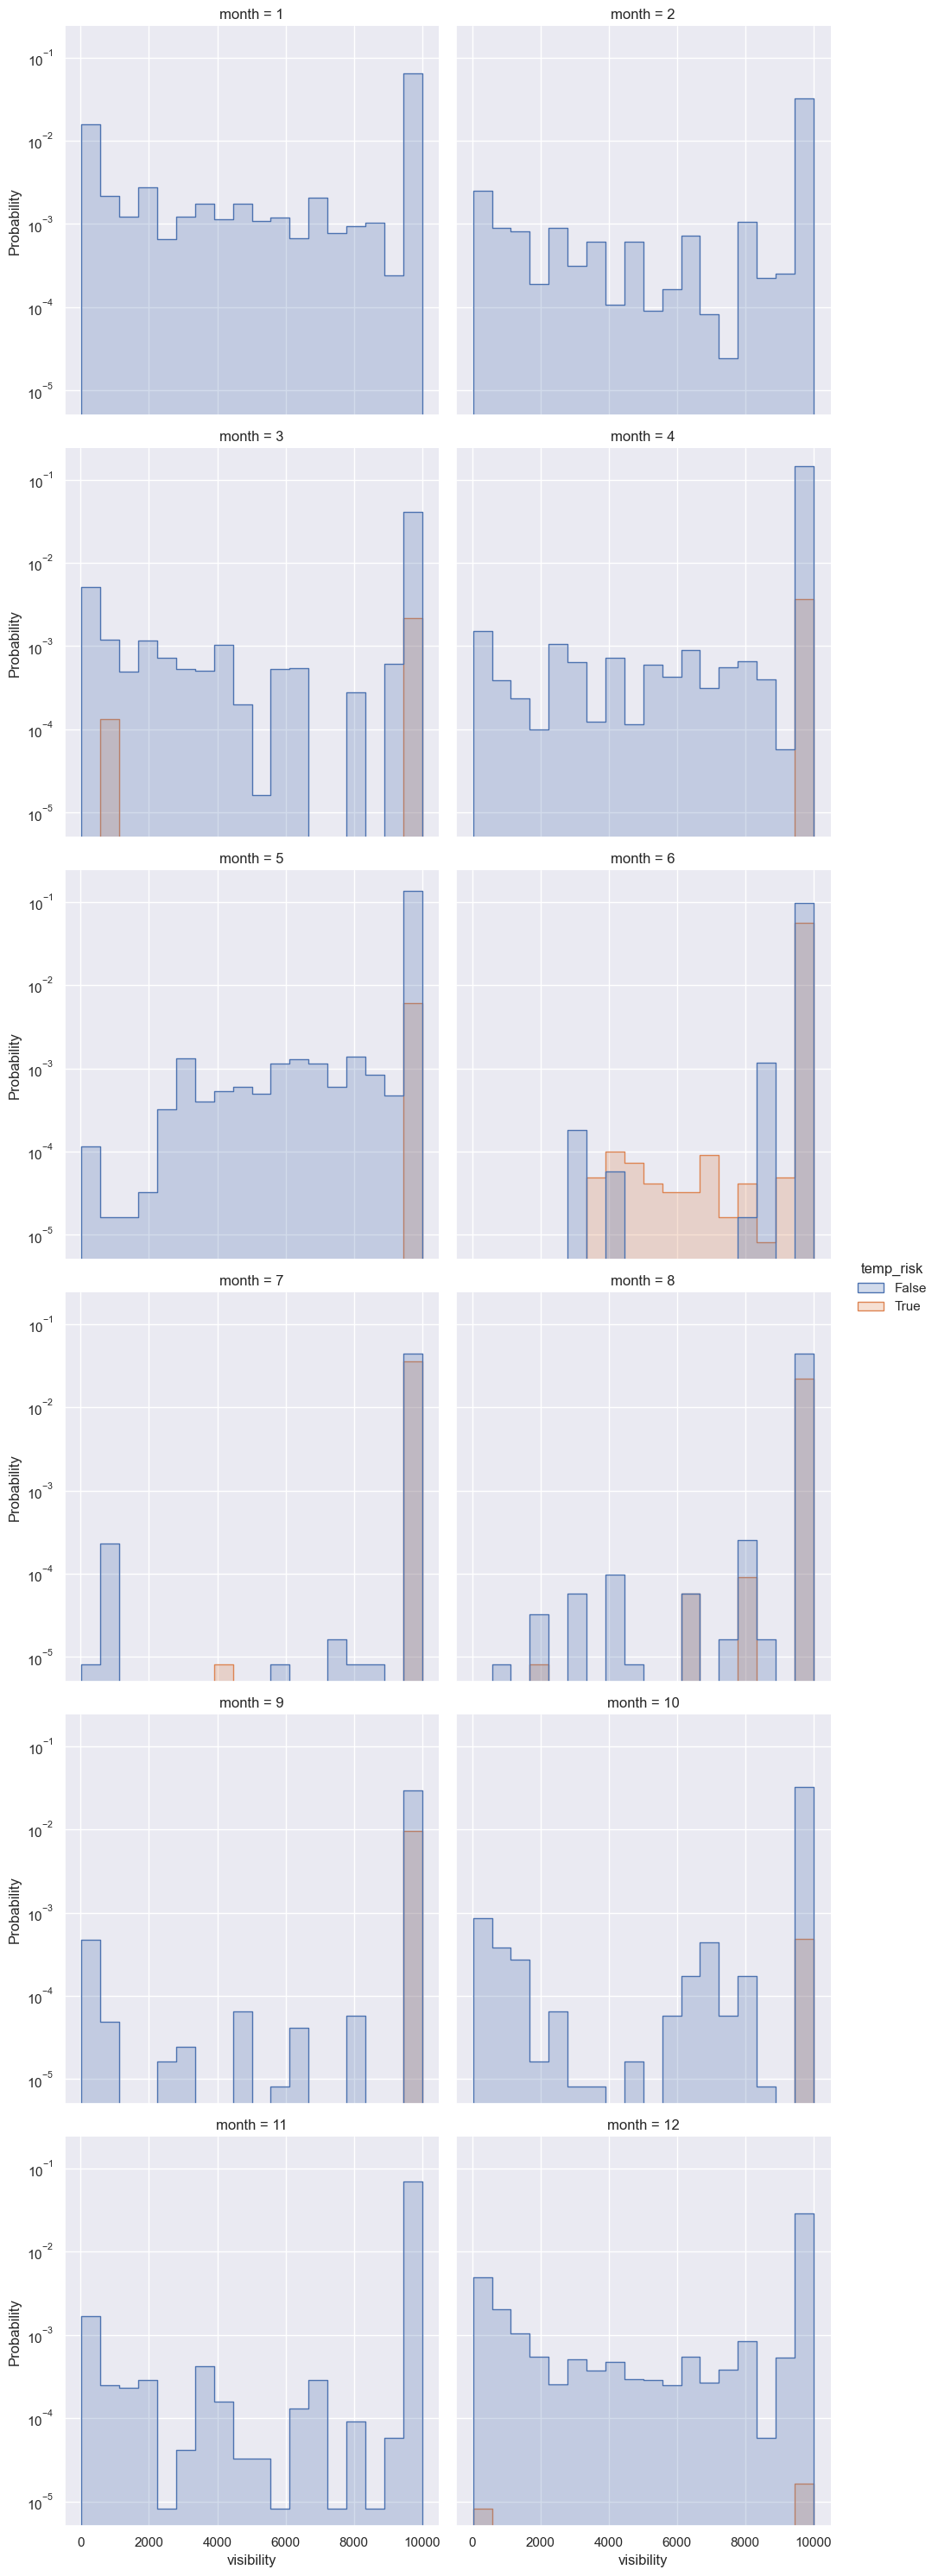

In [148]:
sns.displot(df, x="visibility", hue="temp_risk", col="month", element="step", 
            col_wrap=2, stat="probability", log_scale=(False,True))

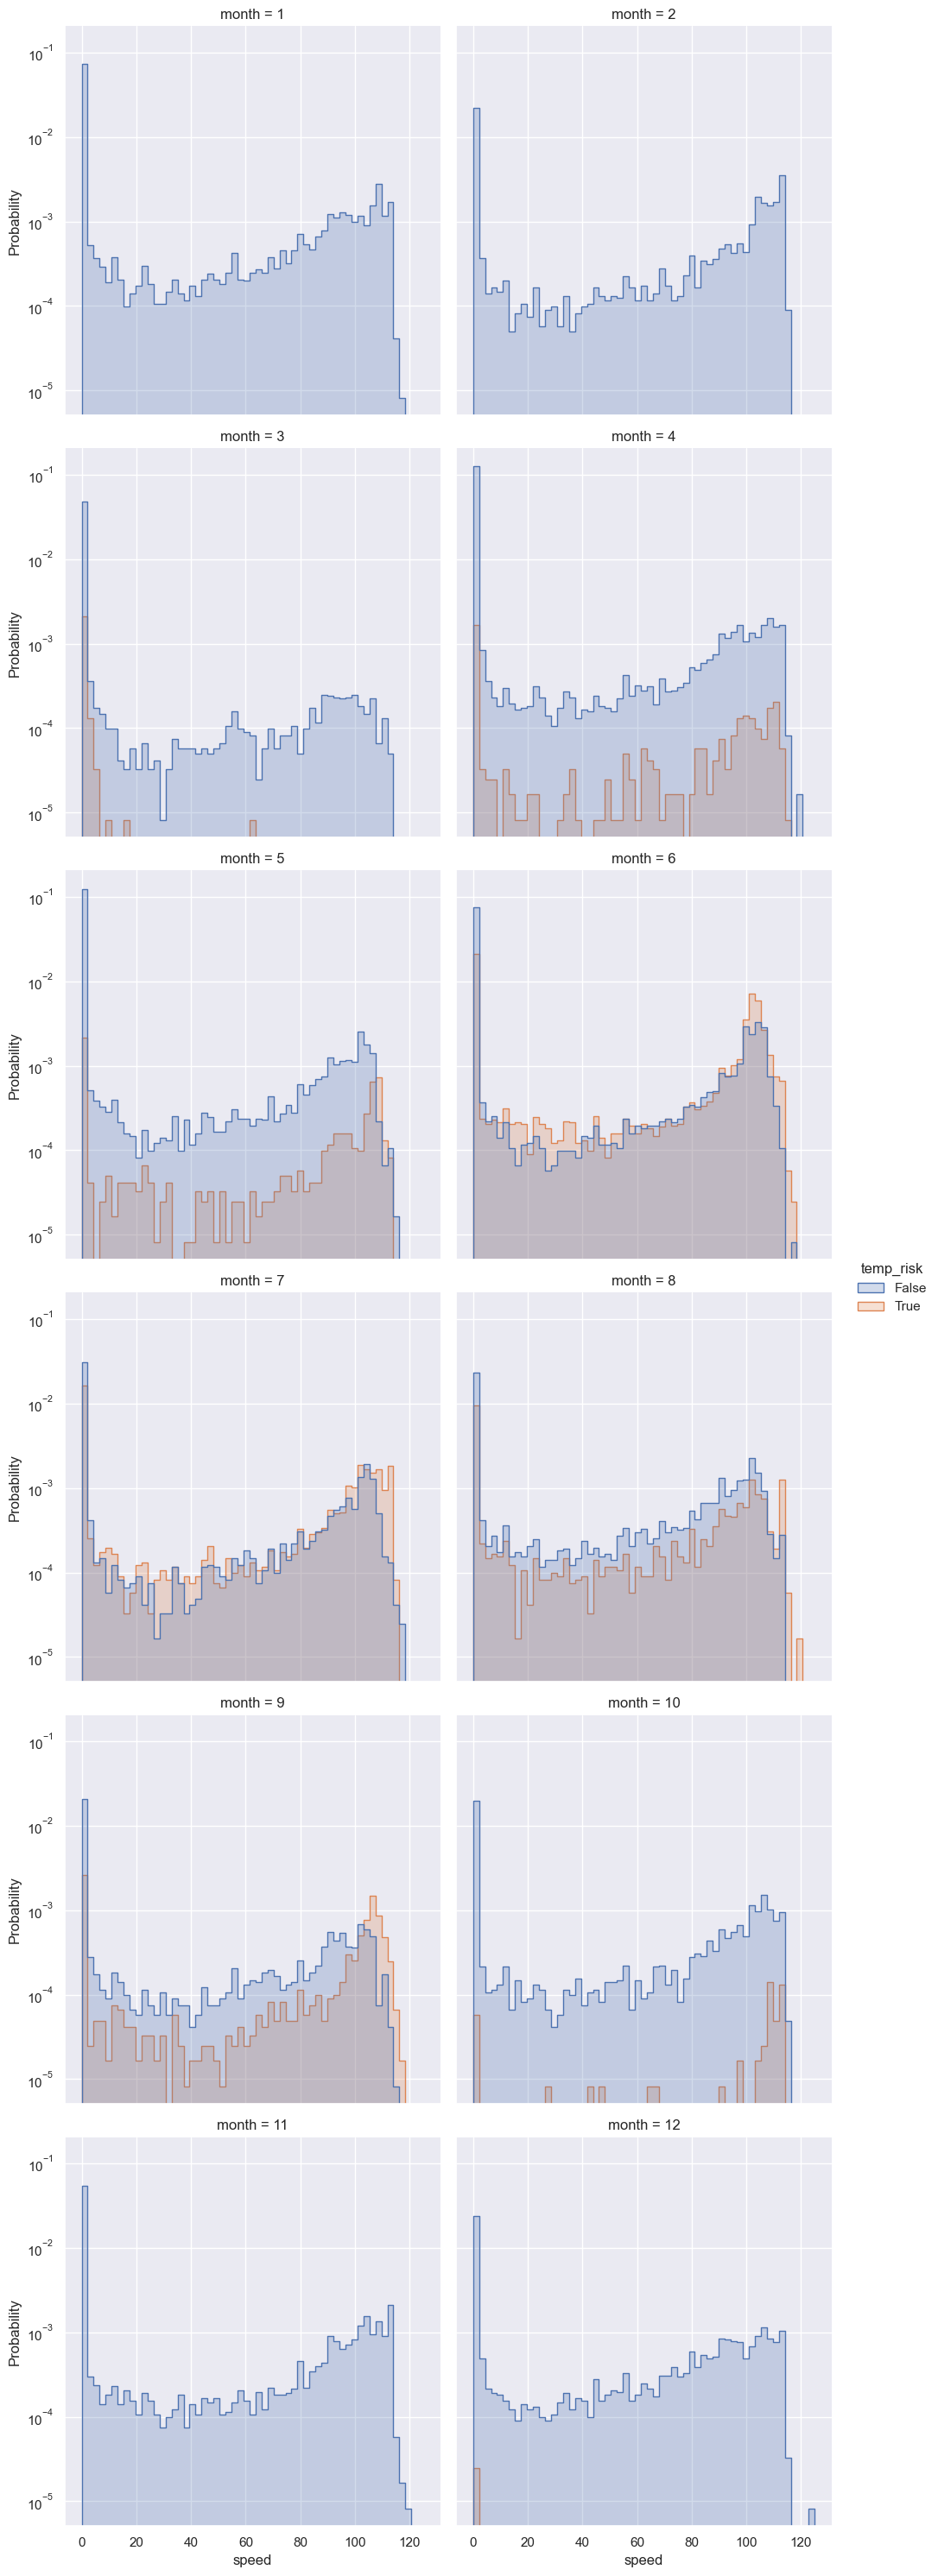

In [149]:
sns.displot(df, x="speed", hue="temp_risk", col="month", element="step",
             col_wrap=2, stat="probability", log_scale=(False,True))

very low Speed & very high Speed can be risky for internal temperature during Summer and Fall

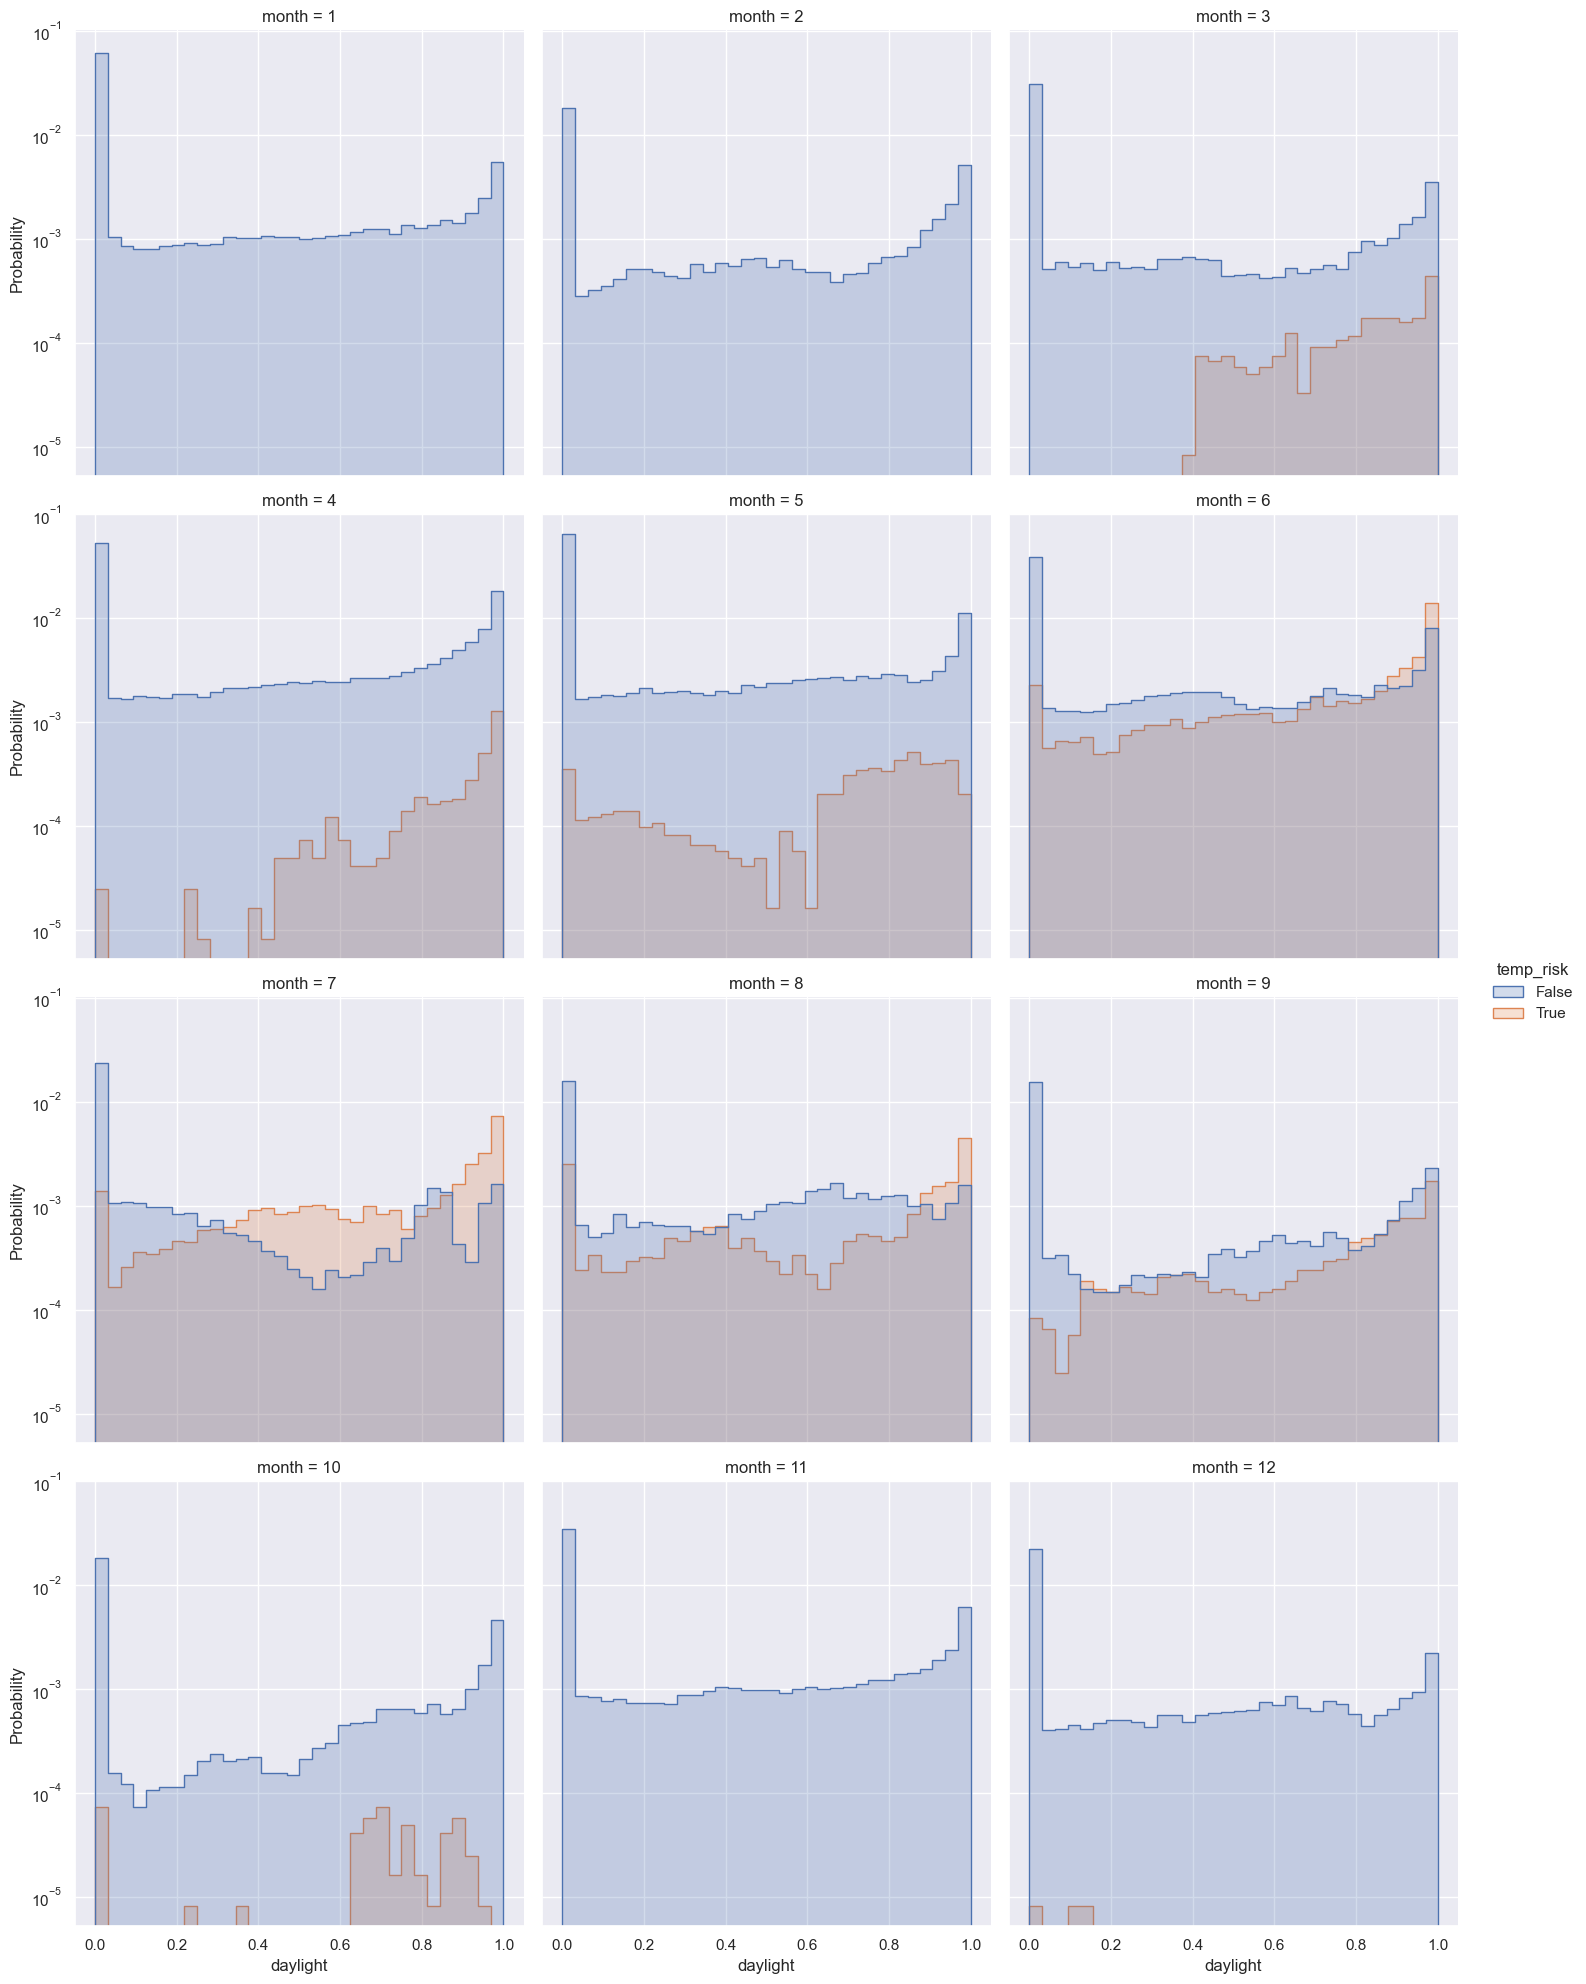

In [286]:
sns.displot(df, x="daylight", hue="temp_risk", col="month", element="step",
             col_wrap=3, stat="probability", log_scale=(False,True))

When Sun is high in the sky,  it can be risky for internal temperature during Summer and Fall

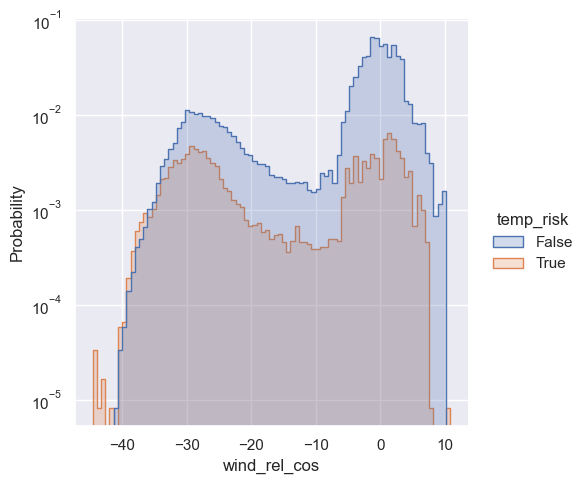

In [172]:
sns.displot(df, x="wind_rel_cos", hue="temp_risk", element="step",
            stat="probability", log_scale=(False,True))

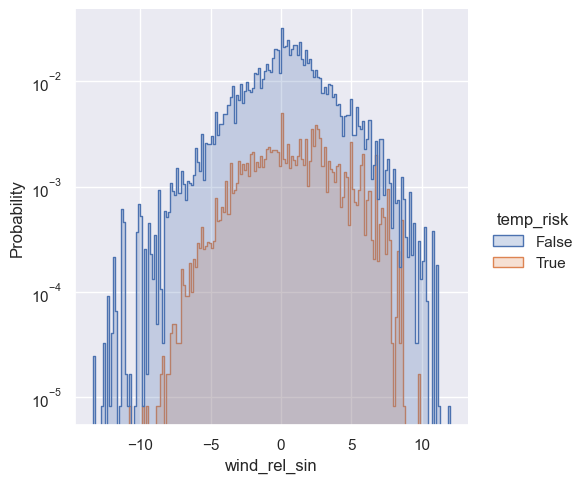

In [173]:
sns.displot(df, x="wind_rel_sin", hue="temp_risk", element="step",
            stat="probability", log_scale=(False,True))

- The relative headwind slightly increases the internal temperature
- But lateral wind has no big impact

### Increase Humidity

- Altitude increases internal humidity 
- Winter months increase internal humidity
- External humidity increases internal humidity
- Clouds increase humidity
- Visibility decrease humidity

In [157]:
df["humi_risk"] = df["humi_mean"] > 80

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_451/2136338280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["humi_risk"] = df["humi_mean"] > 80


In [162]:
df["humi_mean"].describe()

count    121515.000000
mean         80.895206
std          20.142250
min           0.000000
25%          66.720000
50%          87.350000
75%          99.800000
max          99.990000
Name: humi_mean, dtype: float64

<AxesSubplot: xlabel='humi_mean'>

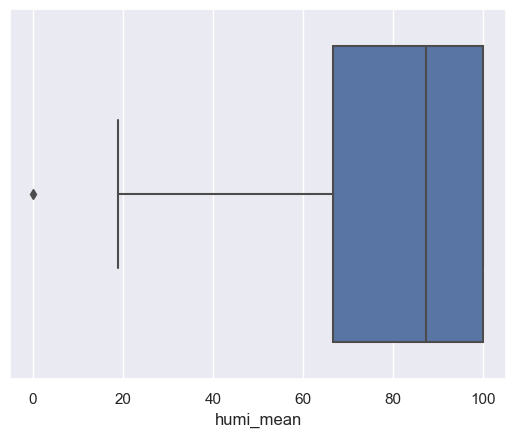

In [166]:
sns.boxplot(df["humi_mean"])

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='humi_risk', ylabel='count'>

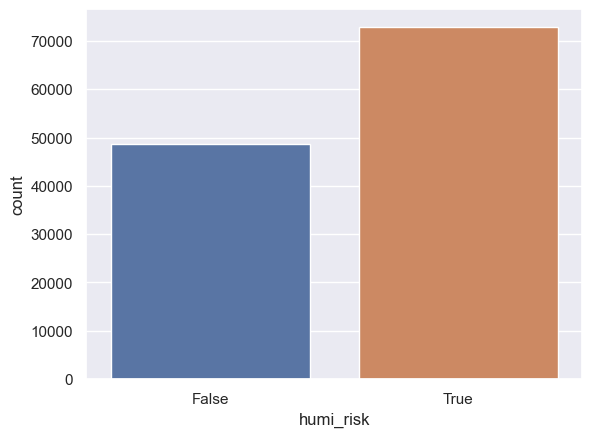

In [167]:
sns.countplot(df["humi_risk"])

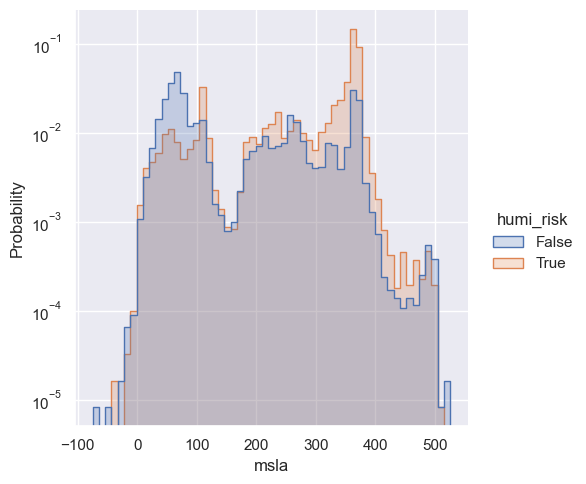

In [169]:
sns.displot(df, x="msla", hue="humi_risk", element="step",
            stat="probability", log_scale=(False,True))

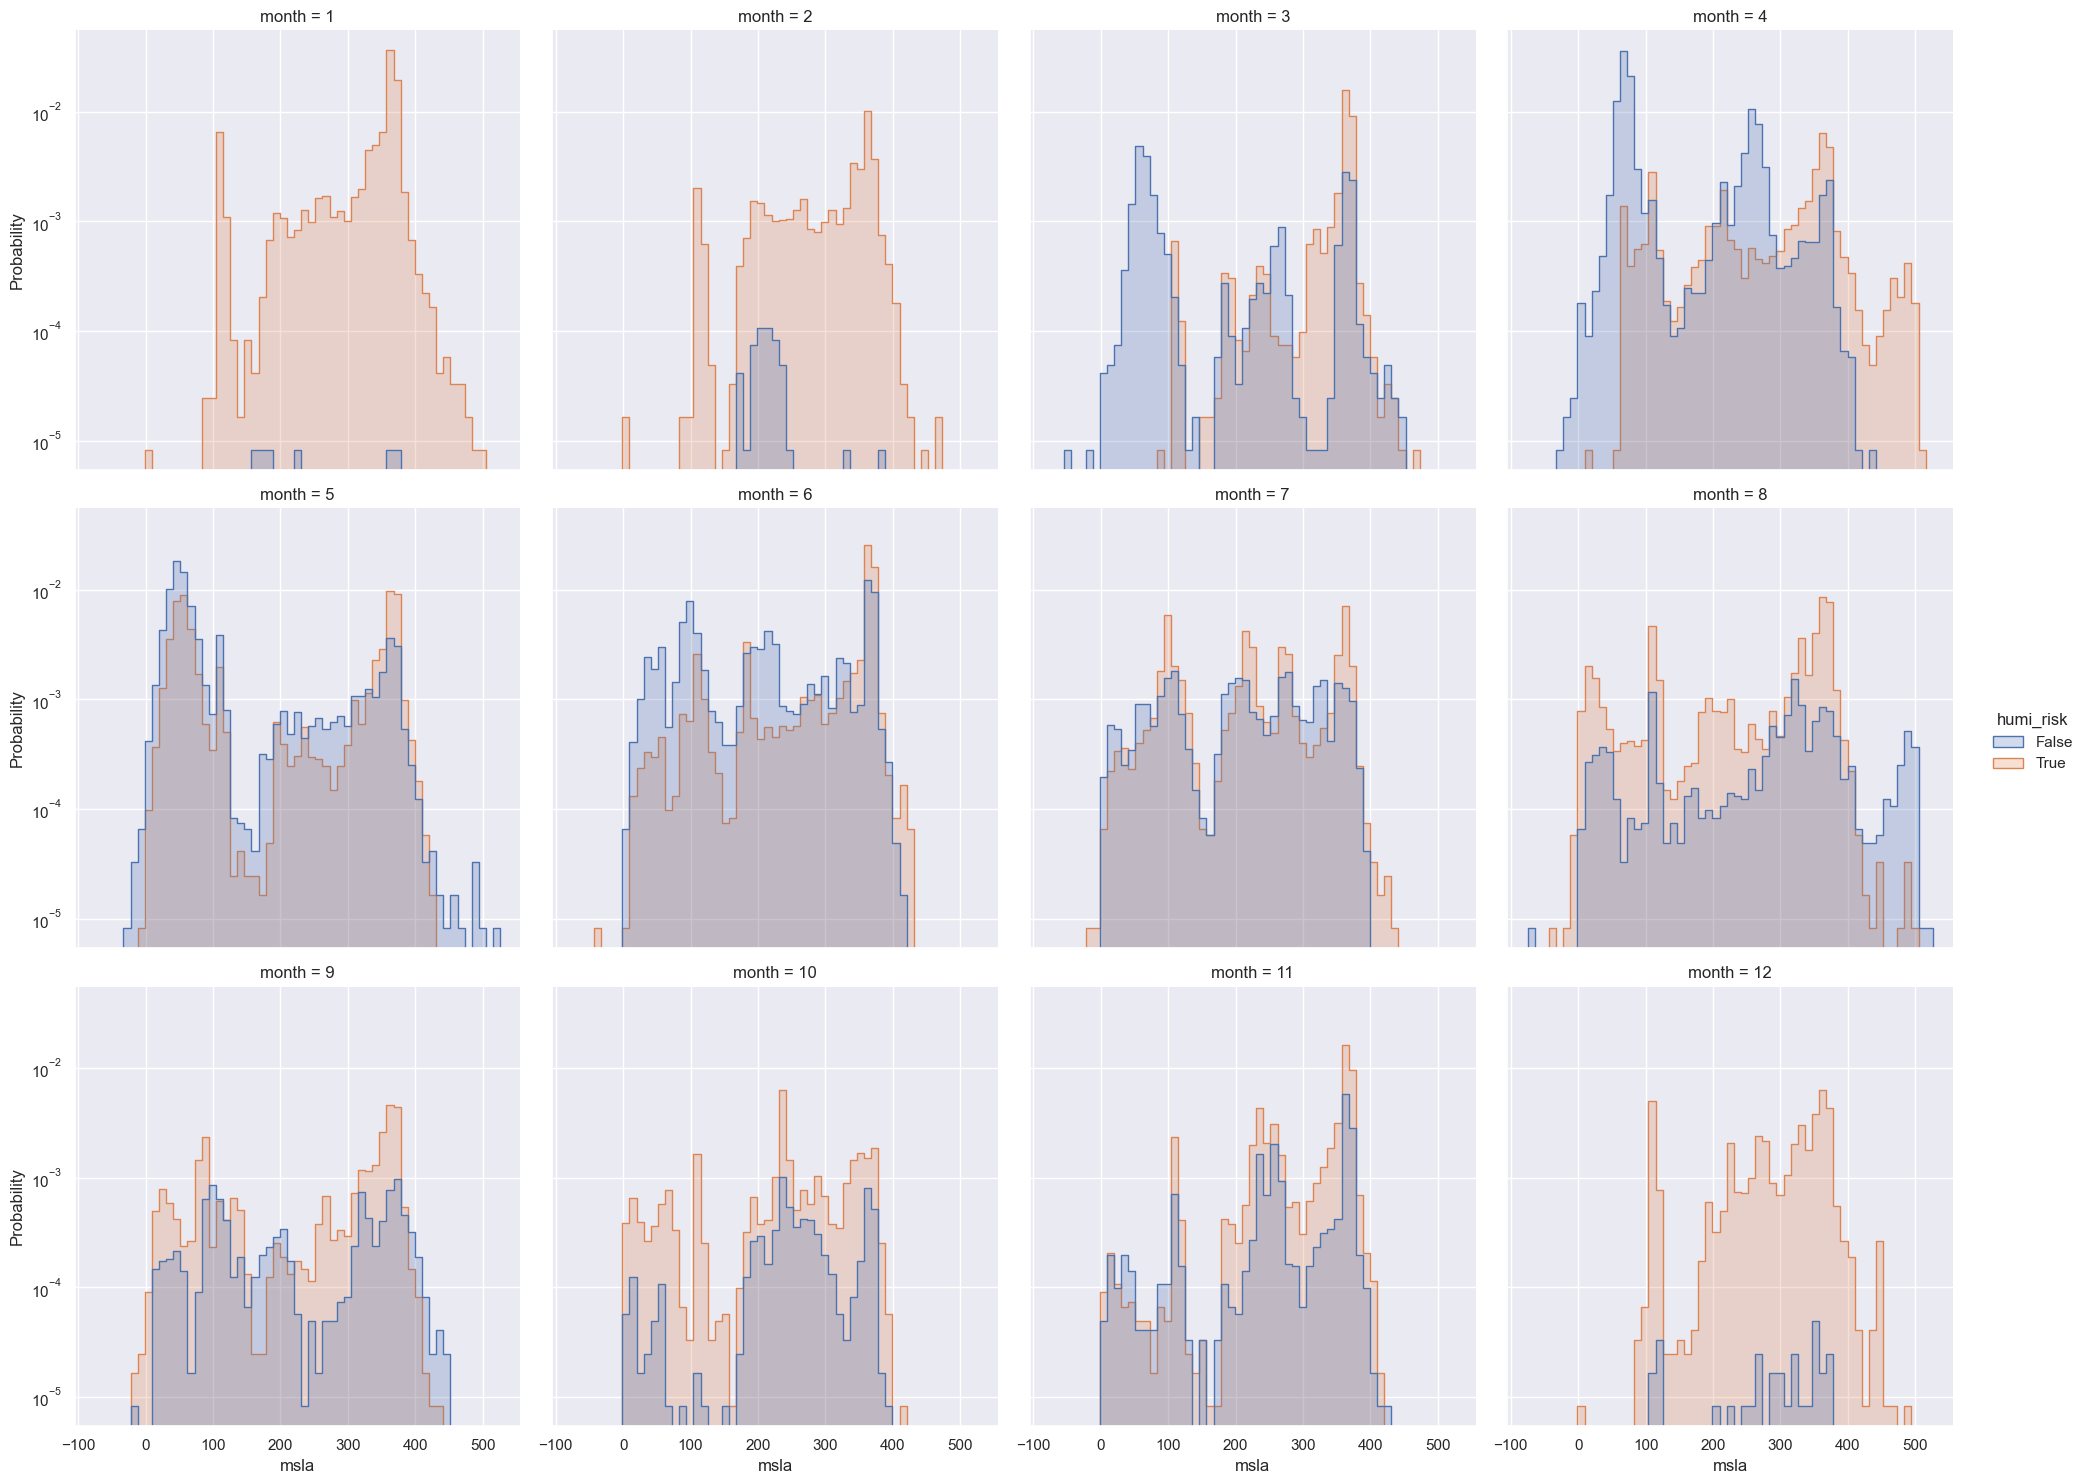

In [287]:
sns.displot(df, x="msla", hue="humi_risk", col="month", element="step",
             col_wrap=4, stat="probability", log_scale=(False,True))

- Humidity risk is higher from december to March.
- Altitude between 200 and 400 m have higher risk

## How do specific weather events (like high winds) or variables such as the proximity of farms to roads contribute to temperature risk?

In [ ]:
# high wind
# rain
# snow


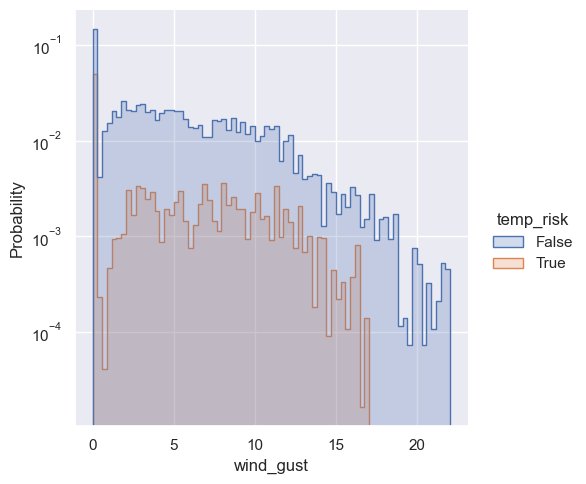

In [176]:
sns.displot(df, x="wind_gust", hue="temp_risk", element="step",
            stat="probability", log_scale=(False,True))

- Less temperature risk when high wind gust

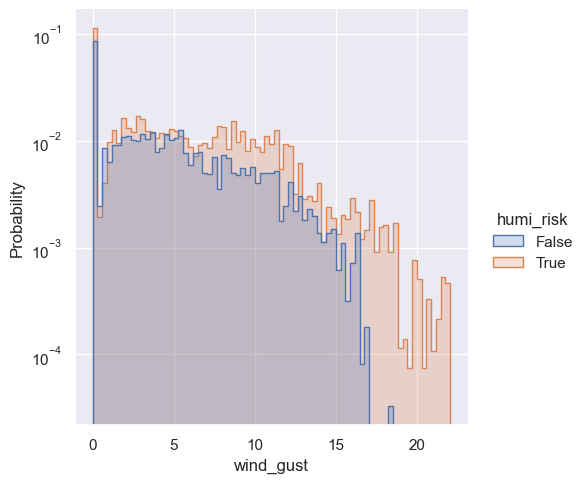

In [175]:
sns.displot(df, x="wind_gust", hue="humi_risk", element="step",
            stat="probability", log_scale=(False,True))

- Higher wind gust impact higher humidity

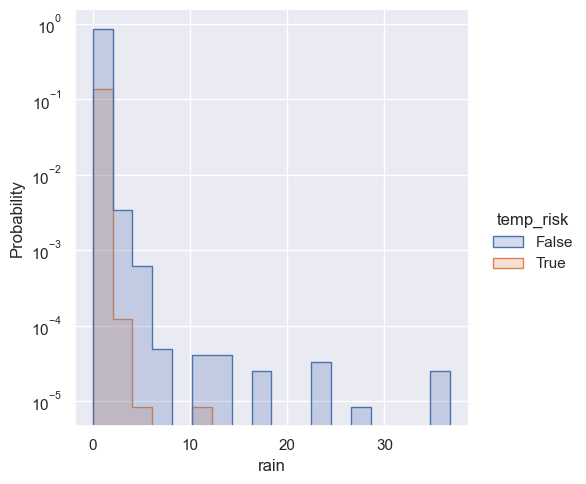

In [177]:
sns.displot(df, x="rain", hue="temp_risk", element="step",
            stat="probability", log_scale=(False,True))

- More temp risk with no rain

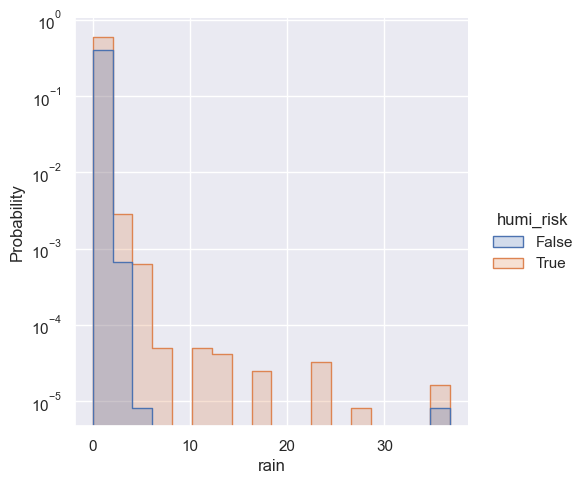

In [178]:
sns.displot(df, x="rain", hue="humi_risk", element="step",
            stat="probability", log_scale=(False,True))

- More humidity when raining

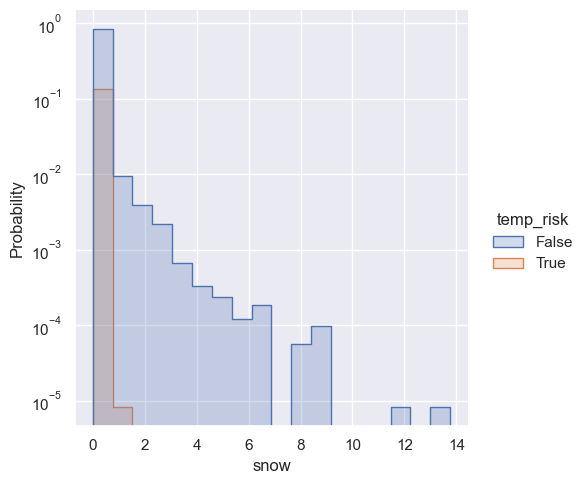

In [179]:
sns.displot(df, x="snow", hue="temp_risk", element="step",
            stat="probability", log_scale=(False,True))

- No temp risk wirh snow

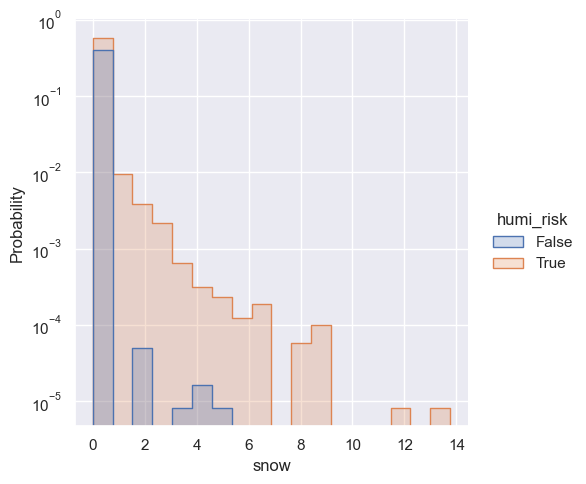

In [180]:
sns.displot(df, x="snow", hue="humi_risk", element="step",
            stat="probability", log_scale=(False,True))

- More risk of humidity with snow

## How can the risk of temperature or humidity-related issues be minimized for long-distance transportation events?

In [183]:
df.columns

Index(['fkReadingsId', 'pkId', 'fkLinkSerialId', 'timestamp', 'speed',
       'acceleration', 'heading', 'direction', 'msla', 'lat', 'long',
       'tsReceived', 'dt', 'sunrise', 'sunset', 'temp', 'feels_like',
       'pressure', 'humidity', 'clouds', 'visibility', 'wind_speed',
       'wind_gust', 'wind_deg', 'rain', 'snow', 'weatherid', 'place_type',
       'accuracy', 'place_name', 'relevance', 'text', 'place', 'region',
       'locality', 'neighborhood', 'postcode', 'country', 'temp_mean',
       'temp_min', 'temp_max', 'humi_mean', 'humi_min', 'humi_max', 'time_num',
       'daylight', 'b_daylight', 'month', 'month_cos', 'month_sin', 'address',
       'lat_reg', 'long_reg', 'wind_deg_cos', 'wind_deg_sin', 'heading_cos',
       'heading_sin', 'wind_rel_cos', 'wind_rel_sin', 'temp_risk',
       'temp_ext_high', 'humi_risk'],
      dtype='object')

<AxesSubplot: xlabel='time_num', ylabel='speed'>

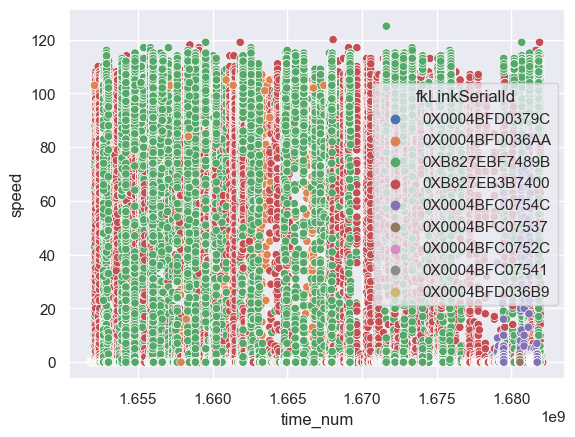

In [184]:
# long transportation event : 
sns.scatterplot(data=df, x="time_num", y="speed" , hue="fkLinkSerialId")

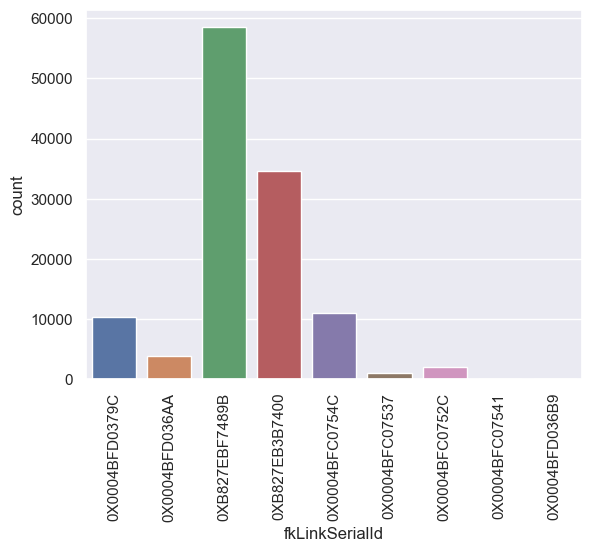

In [186]:
g= sns.countplot(data=df, x="fkLinkSerialId")
for label in g.get_xticklabels():
    label.set_rotation(90)

In [187]:
df["fkLinkSerialId"].unique()

array(['0X0004BFD0379C', '0X0004BFD036AA', '0XB827EBF7489B',
       '0XB827EB3B7400', '0X0004BFC0754C', '0X0004BFC07537',
       '0X0004BFC0752C', '0X0004BFC07541', '0X0004BFD036B9'], dtype=object)

In [211]:
df_veh = df[df["fkLinkSerialId"]=="0XB827EBF7489B"].copy()

In [212]:
df_veh["time_num"].diff()

10891            NaN
10892           23.0
10893           22.0
10894           22.0
10895           22.0
             ...    
112812   -24987276.0
112813          21.0
112814          22.0
112815     1778165.0
112816          22.0
Name: time_num, Length: 58496, dtype: float64

<AxesSubplot: >

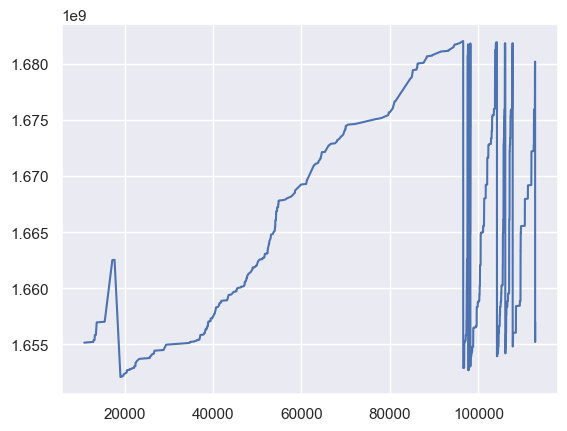

In [213]:
df_veh["time_num"].plot()

<AxesSubplot: ylabel='time_num'>

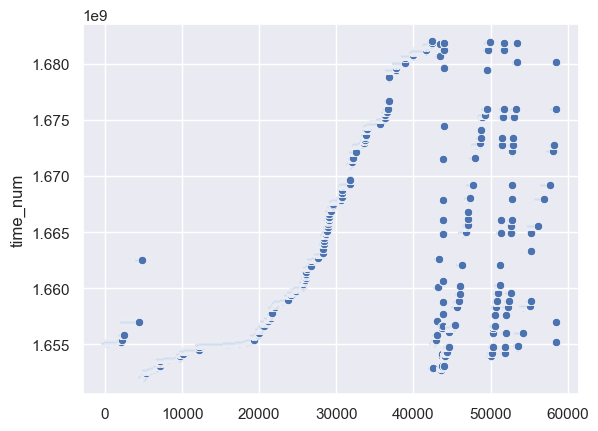

In [214]:
sns.scatterplot(
    x=range(df_veh.shape[0]), 
    y=df_veh["time_num"]
)

<AxesSubplot: >

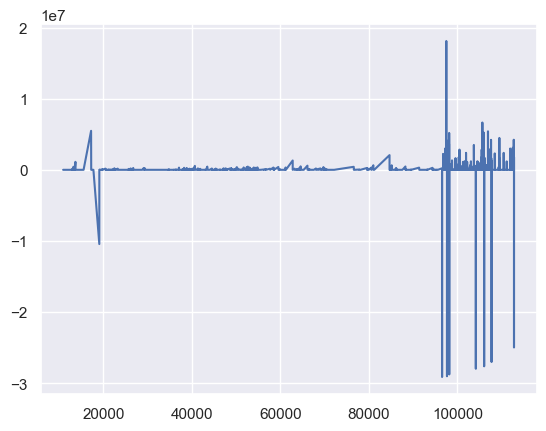

In [215]:
df_veh["time_num"].diff().plot()

In [217]:
df_veh = df_veh.sort_values(by=['time_num'])

In [232]:
df_veh["dt"] = df_veh["time_num"].diff()

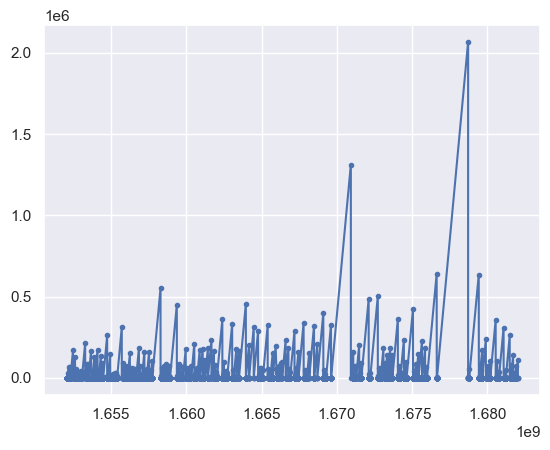

In [233]:
plt.plot(df_veh["time_num"], df_veh["dt"], '.-')

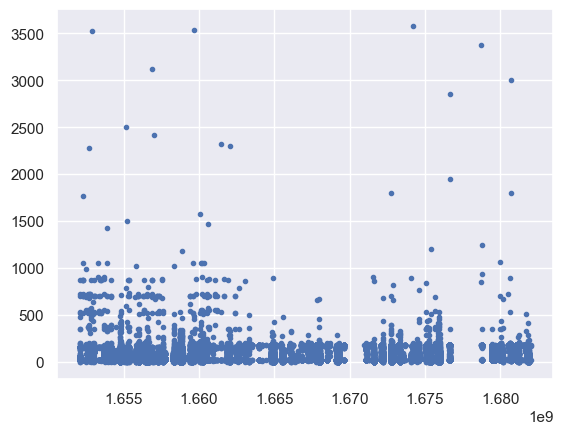

In [239]:
plt.plot(df_veh[df_veh["dt"] < 3600]["time_num"], df_veh[df_veh["dt"] < 3600]["dt"], '.')

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


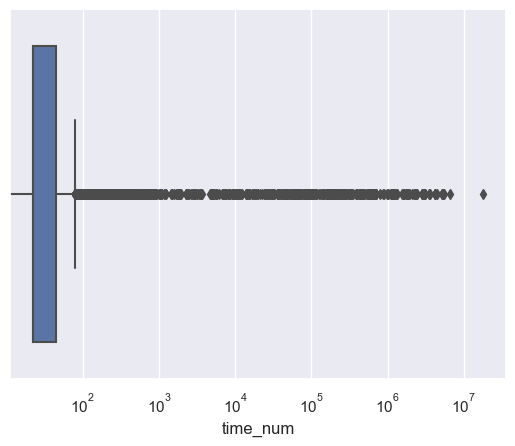

In [197]:
sns.boxplot(df[df["fkLinkSerialId"]=="0XB827EBF7489B"]["time_num"].diff())
ax = plt.gca()
ax.set_xscale("log")

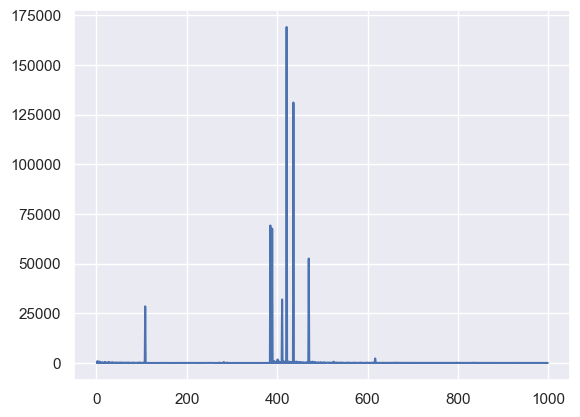

In [248]:
plt.plot(df_veh["dt"].iloc[0:1000].values)

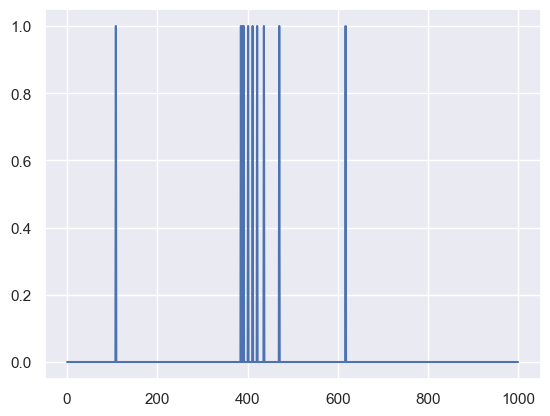

In [251]:
plt.plot(df_veh["dt"].values[0:1000]>1000)

In [252]:
df_veh["flag_trip"] = df_veh["dt"] > 1000

In [254]:
df_veh["trip"]= df_veh["flag_trip"].cumsum()

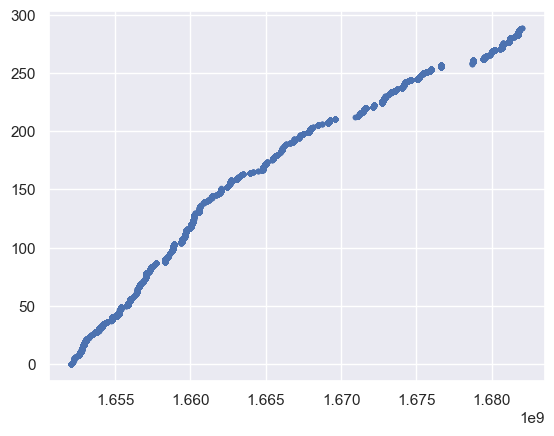

In [255]:
plt.plot(df_veh["time_num"], df_veh["trip"], '.')

<AxesSubplot: xlabel='trip', ylabel='count'>

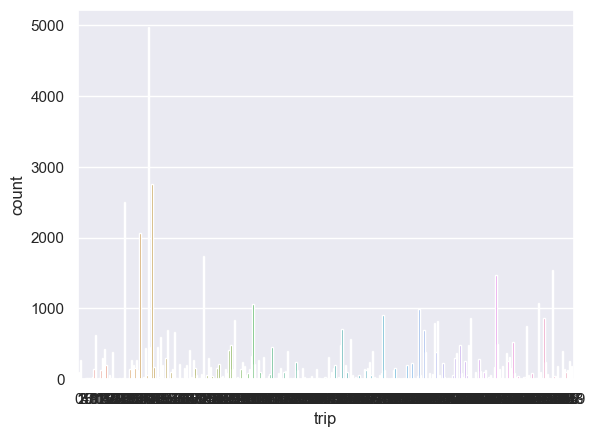

In [259]:
sns.countplot(x=df_veh["trip"])

In [262]:
ser_nb_point = df_veh.groupby("trip")["trip"].count()
ser_nb_point

trip
0      108
1      277
2        4
3        2
4       10
      ... 
285    100
286    126
287    253
288    184
289      4
Name: trip, Length: 290, dtype: int64

In [266]:
ser_nb_point[ser_nb_point> 2000]

trip
27    2496
36    2070
41    4970
43    2749
Name: trip, dtype: int64

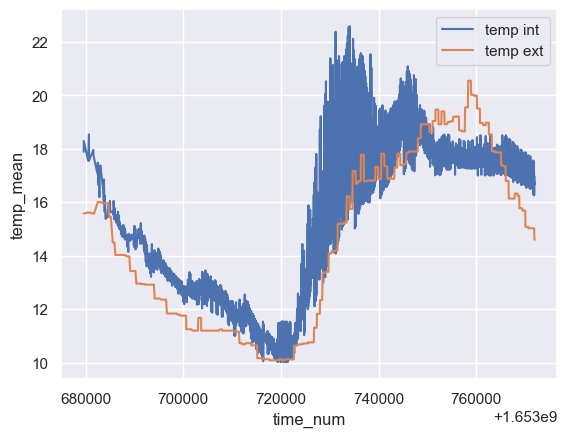

In [271]:
sns.lineplot(data=df_veh[df_veh["trip"] == 27], x="time_num", y="temp_mean", label="temp int")
ax = plt.gca()
sns.lineplot(data=df_veh[df_veh["trip"] == 27], x="time_num", y="temp", ax=ax, label="temp ext")
plt.legend(loc='upper right')

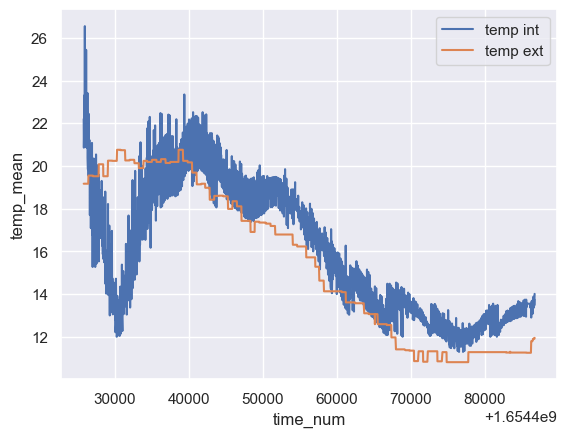

In [272]:
sns.lineplot(data=df_veh[df_veh["trip"] == 36], x="time_num", y="temp_mean", label="temp int")
ax = plt.gca()
sns.lineplot(data=df_veh[df_veh["trip"] == 36], x="time_num", y="temp", ax=ax, label="temp ext")
plt.legend(loc='upper right')

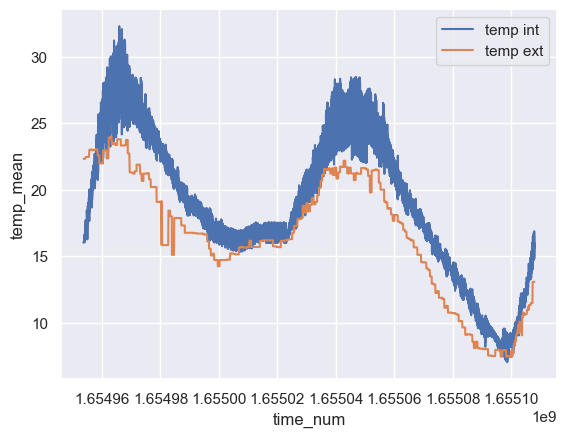

In [273]:
sns.lineplot(data=df_veh[df_veh["trip"] == 41], x="time_num", y="temp_mean", label="temp int")
ax = plt.gca()
sns.lineplot(data=df_veh[df_veh["trip"] == 41], x="time_num", y="temp", ax=ax, label="temp ext")
plt.legend(loc='upper right')

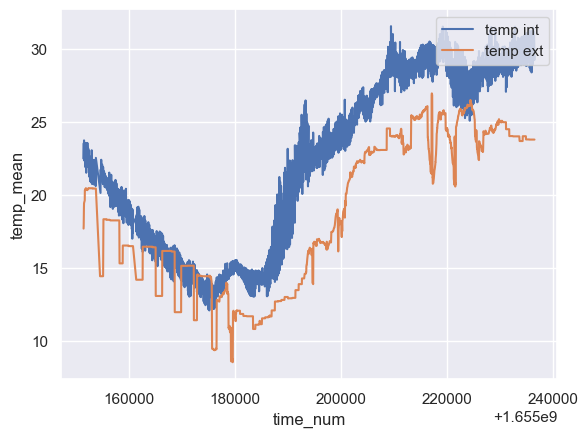

In [274]:
sns.lineplot(data=df_veh[df_veh["trip"] == 43], x="time_num", y="temp_mean", label="temp int")
ax = plt.gca()
sns.lineplot(data=df_veh[df_veh["trip"] == 43], x="time_num", y="temp", ax=ax, label="temp ext")
plt.legend(loc='upper right')

In [276]:
df_veh[df_veh["trip"] == 43]["month"]

11129    6
11130    6
11131    6
11132    6
11133    6
        ..
35628    6
35629    6
35630    6
35631    6
35632    6
Name: month, Length: 2749, dtype: int64

In [282]:
df_veh_43 = df_veh[df_veh["trip"] == 43].copy()

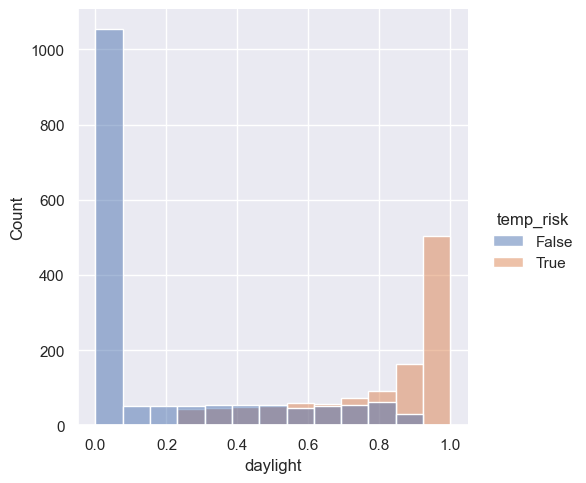

In [283]:
sns.displot(data=df_veh_43, x="daylight", hue="temp_risk")

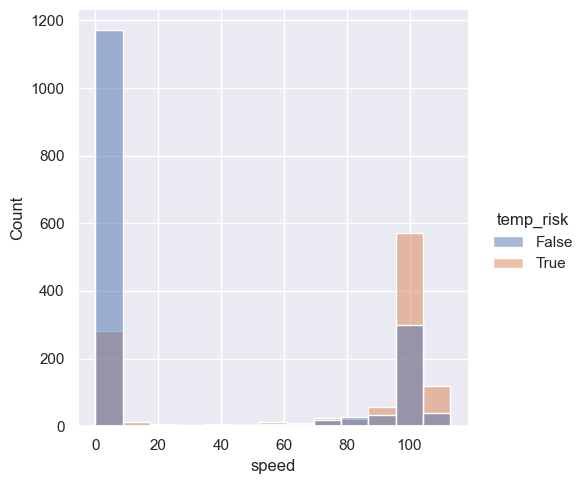

In [284]:
sns.displot(data=df_veh_43, x="speed", hue="temp_risk")

To mitigate temp risk, we can reduce speed and drive close to the night

In [278]:
df_veh["temp_risk"]

19076     False
19077     False
19078     False
19079     False
19080     False
          ...  
104182    False
96543     False
96544     False
96545     False
96546     False
Name: temp_risk, Length: 58496, dtype: bool